<a href="https://colab.research.google.com/github/z4n0/TESI/blob/main/MIP_classifier_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN MIP CLASSIFIER


In [4]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
gdrive = False

In [3]:
import platform
import os

gdrive = False
linux = True 
# Detect if we're running on a Linux system
linux = platform.system() == "Linux"

# Detect if we're in a Google Colab environment by attempting to import google.colab
try:
    from google.colab import drive
# Mount Google Drive
    drive.mount('/content/drive')
    gdrive=True
except ImportError:
    gdrive = False

# Detect if we're in a Kaggle environment by checking for a Kaggle-specific environment variable
kaggle = "KAGGLE_URL_BASE" in os.environ

bool_vars = {'kaggle': kaggle, 'gdrive': gdrive, 'linux': linux}
print("Environment settings:", bool_vars)

Environment settings: {'kaggle': False, 'gdrive': False, 'linux': True}


## install requirements

In [2]:
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())
    import os
else:
    %pip install -r requirements2.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.
open-webui 0.3.30 requires aiohttp==3.10.5, but you have aiohttp 3.9.5 which is incompatible.
open-webui 0.3.30 requires pydantic==2.8.2, but you have pydantic 2.7.1 which is incompatible.
open-webui 0.3.30 requires requests==2.32.3, but you have requests 2.32.2 which is incompatible.
open-webui 0.3.30 requires uvicorn[standard]==0.30.6, but you have uvicorn 0.22.0 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import tifffile
import glob
import random
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from monai.data import Dataset, DataLoader
#from monai.apps import CrossValidation

from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    EnsureTyped,
    Compose,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    RandGaussianNoised,
    #RandAdjustContrastd,
    #MixUpd,
    #ToTensord,
    NormalizeIntensityd
)
from monai.utils import set_determinism
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
import torch.nn.functional as F
from monai.visualize import GradCAMpp,GradCAM  # <-- Import Grad-CAM++
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())

2.6.0+cu124
1.4.0


## PARAMETERS THAT WILL GET LOGGED ON MLFLOW

In [6]:
data_splitting = {
    "random_seed": 42,
    "val_set_size": 0.2, #validation set
    "test_set_size": 0.1,
    "num_folds": 4,
}
# Data Augmentation (Training)
data_augmentation = {
    "resize_spatial_size": (256,256),
    "rand_flip_prob": 0.3,
    "rand_flip_spatial_axes": [0, 1],  # Now a list to hold both axes
    "rand_rotate90_prob": 0.3,
    "rand_rotate90_max_k": 3,
    "rand_gaussian_noise_prob": 0.5,
    "rand_gaussian_noise_mean": 0.0,
    "rand_gaussian_noise_std": 0.1
}
# Data Loading
data_loading = {
    "batch_size": 32,
    "num_workers": 0,
}

# Model
model = {
    "model_name": "DenseNet121",
    "spatial_dims": 2,
    "in_channels": 3,#4
    "out_channels": 2
}
# Training
training = {
    "num_epochs": 40,
    "early_stopping_patience": 12, # Define early stopping patience
    "mixup_alpha": 0,
    "oversample": True,
    "undersample": False,
    "weighted_loss": False,
    "fine_tuning": False,
    "transfer_learning": False,
    "pretrained": False,
    "freezed_layerIndex": None,
}

# import sys
# from pathlib import Path

# # Add the parent directory to Python path if needed
# notebook_dir = Path().absolute()
# if str(notebook_dir.parent) not in sys.path:
#     sys.path.append(str(notebook_dir.parent))

from configs.config_functions import load_cfg

# Use relative path from the notebook location
cfg = load_cfg("configs/vit.yaml")
# If you need to make pretrained dependent on other params, do it after definition:
cfg.training["pretrained"] = cfg.training["transfer_learning"] or cfg.training["fine_tuning"]
print("Pretrained:", cfg.training["pretrained"])

if cfg.training["transfer_learning"] and cfg.training["fine_tuning"]:
    raise ValueError("DO TRANSFER LEARNING OR FINE TUNING, NOT BOTH")

cfg.optimizer = {
    "learning_rate": 1e-3 if not cfg.training["transfer_learning"] else 5e-5,
    "optimizer_name": "Adam",
    "weight_decay": 1e-5,
}

# Set a fixed random seed for reproducibility
SEED = cfg.data_splitting["random_seed"]
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

monai.utils.set_determinism(seed=SEED)

Configuration loaded from configs/vit.yaml
Pretrained: False


# UNIFIED DATA SELECTION

In [7]:
from utils.directory_functions import get_data_directory, get_base_directory
data_dir = get_data_directory(kaggle, gdrive,linux)
base_dir = get_base_directory(kaggle, gdrive,linux)

you are in linux
/home/zano/Documents/TESI/3c_version


## MSA VS CONTROL

In [ ]:
class1_name = "MSA"
class0_name = "control"
# Construct paths to MSA and control image directories
msa_dir = os.path.join(data_dir, class1_name)
control_dir = os.path.join(data_dir, class0_name)

NameError: name 'os' is not defined

## MSA VS PD

In [8]:
class1_name = "MSA"
class0_name = "PD"
# Construct paths to MSA and control image directories
msa_dir = os.path.join(data_dir, class1_name)
control_dir = os.path.join(data_dir, class0_name)

## MSA-P VS PD

In [21]:
class1_name = "MSA-P"
class0_name = "PD"
# Construct paths to MSA and control image directories
msa_dir = os.path.join(data_dir, class1_name)
control_dir = os.path.join(data_dir, class0_name)

## MSA-P VS MSA-C

In [62]:
class1_name = "MSA-P" #majority class
class0_name = "MSA-C"
# Construct paths to MSA and control image directories
msa_dir = os.path.join(data_dir, class1_name)
control_dir = os.path.join(data_dir, class0_name)

# DATA EXTRACTION

MSA-P images: 'gh' count: 31, 'vaso' count: 0
PD images: 'gh' count: 32, 'vaso' count: 0
After removing 'vaso' images:
MSA-P images: 'gh' count: 31, 'vaso' count: 0
PD images: 'gh' count: 32, 'vaso' count: 0


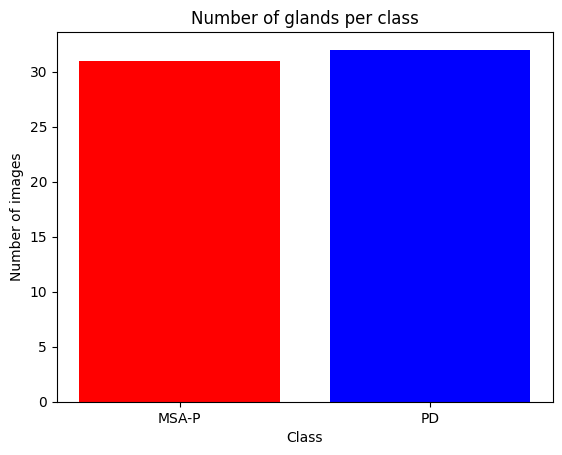

Checking image shapes after initial loading:
dtype: uint8  Image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5435.lif - 5435 DL VIP r TH b Sinapto gr 63x z2 gh pinhole 1 z 05ies009_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5435.lif - 5435 DL VIP r TH b Sinapto gr 63x z2 gh2 pinhole 1 z 05_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5717.lif - 5717 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh 2 pinhole 1 z 05_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_5717.li

In [22]:
from utils.data_extraction_functions import extract_labels_meaning
# Get sorted lists of MSA and control image file paths
# Filter out 'vaso' images from msa_images_paths
msa_images_paths = sorted(glob.glob(os.path.join(msa_dir, "*.tif")))
control_images_paths = sorted(glob.glob(os.path.join(control_dir, "*.tif")))

# Check if any TIFF images were found, raise an error if not
if len(msa_images_paths) == 0:
    raise FileNotFoundError(f"No TIFF image file found in {msa_dir}")
if len(control_images_paths) == 0:
    raise FileNotFoundError(f"No TIFF image file found in {control_dir}")

# Count 'gh' and 'vaso' in MSA images
msa_gh_count = sum('gh' in path.lower() for path in msa_images_paths)
msa_vaso_count = sum('vaso' in path.lower() for path in msa_images_paths)  # Should be 0 now
print(f"{class1_name} images: 'gh' count: {msa_gh_count}, 'vaso' count: {msa_vaso_count}")

# Count 'gh' and 'vaso' in control images
control_gh_count = sum('gh' in path.lower() for path in control_images_paths)
control_vaso_count = sum('vaso' in path.lower() for path in control_images_paths)
print(f"{class0_name} images: 'gh' count: {control_gh_count}, 'vaso' count: {control_vaso_count}")
#removing the vaso images IF NEEDED else skip this
msa_images_paths = [path for path in msa_images_paths if 'vaso' not in path.lower()] # Remove 'vaso' images from MSA images
control_images_paths = [path for path in control_images_paths if 'vaso' not in path.lower()] # Remove 'vaso' images from control images

print("After removing 'vaso' images:")
msa_gh_count = sum('gh' in path.lower() for path in msa_images_paths)
msa_vaso_count = sum('vaso' in path.lower() for path in msa_images_paths)  # Should be 0 now
print(f"{class1_name} images: 'gh' count: {msa_gh_count}, 'vaso' count: {msa_vaso_count}")

control_gh_count = sum('gh' in path.lower() for path in control_images_paths)
control_vaso_count = sum('vaso' in path.lower() for path in control_images_paths)
print(f"{class0_name} images: 'gh' count: {control_gh_count}, 'vaso' count: {control_vaso_count}")

# visualizing the number of images per class
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Number of glands per class")
plt.bar([class1_name, class0_name], [msa_gh_count, control_gh_count], color=['red', 'blue'])
plt.show()

## --- Debug: Check image shapes after loading ---
print("Checking image shapes after initial loading:")
for img_path in msa_images_paths:# + control_images_paths:
    img = tifffile.imread(img_path)  # Use tifffile to read the image, returns numpy array
    filename = os.path.basename(img_path)
    print(f"dtype: {img.dtype}  Image: {filename}, Shape: {img.shape}")

# Print example image paths and counts
#print("Example MSA image path:", msa_images_paths[0])
#print("Example Control image path:", control_images_paths[0])
print(f"Found {len(msa_images_paths)} MSA and {len(control_images_paths)} control images.")
print("Total:", len(msa_images_paths) + len(control_images_paths))

# Combine image paths and create corresponding labels (1 for MSA, 0 for control)
images_paths = msa_images_paths + control_images_paths
label_msa = [1]
label_control = [0]
labels = label_msa * len(msa_images_paths) + label_control * len(control_images_paths)
combined = list(zip(images_paths, labels))

#keep minority label for oversampling/undersampling
minority_label = 1 if len(msa_images_paths) < len(control_images_paths) else 0

images_paths, labels = zip(*combined) # Unzip the combined list back into separate tuples
print(images_paths)
# If you prefer to use ALL data for k-fold (no separate test set), just do:
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)

# TEST SPLIT AND DATA VISUALIZATION

## TEST SET SPLIT

In [23]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
train_images_paths_np, test_images_paths, train_true_labels_np, test_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size= cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=cfg.data_splitting["random_seed"]
)
#
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths_np) #contains the images paths
train_true_labels_np = np.array(train_true_labels_np) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths_np))

56 training images
7 test images
['/home/zano/Documents/TESI/3c_version/MSA-P/MAX_7132.lif - 7132 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA-P/MAX_7144.lif - 7144 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_6690.lif - 6690 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_6340.lif - 6340 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_6577.lif - 6577 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_7229.lif - 7229 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA-P/MAX_5745.lif - 5745 DL VIP r TH b Sinapto gr 63x z2 gh2 pinhole 1 z 05_3ch.tif']
<class 'numpy.ndarray'>


In [41]:
train_images_paths_np = images_paths_np #contains the images paths
train_true_labels_np = labels_np #contains the labels

test_dir = os.path.join(data_dir, "TEST")
test_images_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
test_images_paths_np = np.array(test_images_paths)
print(f"class 0:{class0_name} class 1:{class1_name}")

#nice result if i flip the labels dont know why

test_msa_ids = [7144,7120,7239,7293]
test_pd_ids = [7155,7222,7229,7284]

def get_label(path):
    id_num = int(os.path.basename(path).split("_")[0])
    if id_num in test_msa_ids:
        return 1
    elif id_num in test_pd_ids:
        return 0
    else:
        raise ValueError(f"Unknown ID: {id_num}")

test_true_labels = [get_label(path) for path in test_images_paths]
true_test_labels_np = np.array(test_true_labels)
print(f"Found {len(test_images_paths)} test images.")
print(test_images_paths_np)
print(true_test_labels_np)

class 0:PD class 1:MSA-P
Found 16 test images.
['/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7120_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7120_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7144_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7144_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7155_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7155_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7222_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7222_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7229_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7229_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7239_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7239_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7284_gh 2_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/TEST/7284_gh_rgb.tif'
 '/home/zano/Documents/TESI/TESI/IMMAGINI/T

## TEST SET VISUALIZATIONS

In [ ]:
from utils.data_visualization_functions import print_image_statistic

# Call the function with test images and their labels
print_image_statistic(test_images_paths, test_labels, num_samples=10, class1_name=class1_name, class0_name=class0_name)

In [ ]:
from utils.data_visualization_functions import visualize_tiff
# Example usage:
for i in range(len(test_images_paths)):
    print(f" Image{i} : {test_images_paths[i]}")
    visualize_tiff(test_images_paths[i])


# TRAINING

## helper functions

In [13]:
from utils.train_functions import (
    train_epoch,
    val_epoch,
    setup_model,
    print_model_summary,
    plot_cv_results,
    train_epoch_mixUp,
    print_layers,
    oversample_minority,
    undersample_majority,
)

from utils.data_visualization_functions import visualize_dict_image

## Training

In [24]:
import sys

# Add the parent directory to Python path to make configs package accessible
sys.path.append(os.path.dirname(os.getcwd()))

from configs.config_functions import load_cfg

yaml_path = "/home/zano/Documents/TESI/TESI/configs/vit.yaml"
cfg = load_cfg(yaml_path)

from utils.transformations_functions import get_transforms

print("model name: ",cfg.get_model_name())
cfg.set_freezed_layer_index(None)
cfg = load_cfg(yaml_path)
train_transforms, val_transforms, test_transforms = get_transforms(cfg)

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/vit.yaml
model name:  ViT
Configuration loaded from /home/zano/Documents/TESI/TESI/configs/vit.yaml
Using pretrained model: False
Model ViT not supported


In [26]:
from configs import Config_loader
from utils.train_functions import (
    train_epoch,
    val_epoch,
    setup_model,
    print_model_summary,
    plot_cv_results,
    train_epoch_mixUp,
    print_layers,
    oversample_minority,
    undersample_majority,
    )
from monai.networks.nets import ViT

def freeze_layers_up_to(model, cfg: Config_loader):
    """
    Print all layers of a model and freeze layers based on the configuration's freezed_layerIndex.
    Only prompts for input on the first fold.
    """
    layers = [name for name, _ in model.named_parameters()]

    # Only print layers and ask for input if freezed_layerIndex is not set
    if cfg.get_freezed_layer_index() is None:
        print("Model Layers:")
        for i, layer in enumerate(layers):
            print(f"{i}: {layer}")

        while True:
            try:
                end_index = int(input(f"Enter the index of the last layer to freeze (0 to {len(layers)-1}): "))
                if 0 <= end_index < len(layers):
                    cfg.set_freezed_layer_index(end_index)
                    break
                else:
                    print("Invalid index. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    # Use the stored index for all folds
    end_index = cfg.get_freezed_layer_index()

    # Freeze layers up to and including the selected index
    for i, (name, param) in enumerate(model.named_parameters()):
        param.requires_grad = i > end_index
        
def setup_model(cfg):
    """
    Set up the model for training.

    Args:
        cfg.model (dict): Dictionary containing model parameters.
            - spatial_dims (int): Number of spatial dimensions (2D or 3D).
            - in_channels (int): Number of input channels.
            - out_channels (int): Number of output channels (classes).
        cfg.training (dict): Dictionary containing training parameters.
            - pretrained (bool): Whether to use a pretrained model.
            - distributed (bool, optional): Whether to use distributed data parallelism.

    Returns:
        model (torch.nn.Module): The initialized model.
        device (torch.device): The device on which the model is located (CPU or GPU).
    """
    # Check CUDA availability first
    if not torch.cuda.is_available():
        print("CUDA is not available. Using CPU.")
        device = torch.device("cpu")
    else:
        n_gpus = torch.cuda.device_count()
        print(f"Found {n_gpus} GPU{'s' if n_gpus > 1 else ''}.")
        device = torch.device("cuda:0")

    model = ViT(
        in_channels=3,
        img_size=(224, 224),
        patch_size=(32, 32),
        hidden_size=128,
        mlp_dim=256,
        num_layers=4,
        num_heads=4,  # Note: you had 4 heads before; adjust as desired.
        proj_type='conv',
        pos_embed_type='learnable',
        classification=True,
        save_attn=True,   # Enable saving attention weights!
        spatial_dims=2
    )
    
    # model = ViT(
    #       in_channels=3, 
    #       img_size=(224,224),
    #       patch_size = (32,32),
    #       proj_type='conv', 
    #       pos_embed_type='sincos', 
    #       classification=True,
    #       spatial_dims=2
    #       )
    
    # Handle multi-GPU if available
    if torch.cuda.device_count() > 1:
        model = nn.parallel.DistributedDataParallel(model) if cfg.training.get("distributed", False) else nn.DataParallel(model)

    # Move model to the appropriate device (CPU or GPU)
    model = model.to(device)

    return model, device

def train_epoch_vit(model, loader, optimizer, loss_function, device):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    for batch in loader:
        images_batch, labels_batch = batch["image"].to(device), batch["label"].to(device).long()
        # pixel are correctly between 0 and 1
        optimizer.zero_grad()
        outputs, hidden_states_out = model(images_batch)
        #print(f"output(logits) {outputs}")
        loss = loss_function(outputs, labels_batch)
        loss.backward()
        # Debug: Check gradients
        # for name, param in model.named_parameters():
        #     if param.grad is not None and torch.all(param.grad == 0):
        #         print(f"Zero gradients in layer: {name}")
        # After loss.backward()
        total_grad = sum(p.grad.abs().sum() for p in model.parameters() if p.grad is not None)
        #print(f"Gradient magnitude: {total_grad.item()}")
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Add this
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels_batch).sum().item()
        total += labels_batch.size(0)
    return epoch_loss / len(loader), correct / total

def val_epoch_vit(model, loader, loss_function, device):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images_batch, labels_batch = batch["image"].to(device), batch["label"].to(device).long()
            outputs, hidden_states_out = model(images_batch)

            loss = loss_function(outputs, labels_batch)

            # Calculate standard metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels_batch).sum().item()
            total += labels_batch.size(0)

            # Store predictions and labels for F1 score and balanced accuracy
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    # Calculate metrics
    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='binary')  # Use 'binary' for binary classification
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    return epoch_loss / len(loader), accuracy, f1, balanced_acc

## K-fold cv


===== FOLD 1 / 4 =====
 starting train samples: 63 | val samples: 21
batch size: 63
 After oversampling  => train samples: 82 | val samples: 21
Model Architecture:
Total parameters: 1,192,322
Trainable parameters: 1,192,322
Non-trainable parameters: 0
learning rate: 0.001
 Epoch 1/40: Train Loss: 0.7600, Train Acc: 0.5732, Val Loss: 0.9092, Val Acc: 0.3333, Val F1: 0.0000, Val Balanced Acc: 0.5000, lr: 0.00100, 
 Epoch 2/40: Train Loss: 0.6635, Train Acc: 0.5854, Val Loss: 0.6951, Val Acc: 0.6667, Val F1: 0.8000, Val Balanced Acc: 0.5000, lr: 0.00098, 
 Epoch 3/40: Train Loss: 0.7798, Train Acc: 0.5122, Val Loss: 0.6116, Val Acc: 0.6667, Val F1: 0.8000, Val Balanced Acc: 0.5000, lr: 0.00099, 
 Epoch 4/40: Train Loss: 0.6840, Train Acc: 0.5732, Val Loss: 0.7390, Val Acc: 0.3333, Val F1: 0.0000, Val Balanced Acc: 0.5000, lr: 0.00099, 
 Epoch 5/40: Train Loss: 0.6768, Train Acc: 0.5000, Val Loss: 0.6933, Val Acc: 0.4286, Val F1: 0.2500, Val Balanced Acc: 0.5714, lr: 0.00098, 
 Epoch 6/40

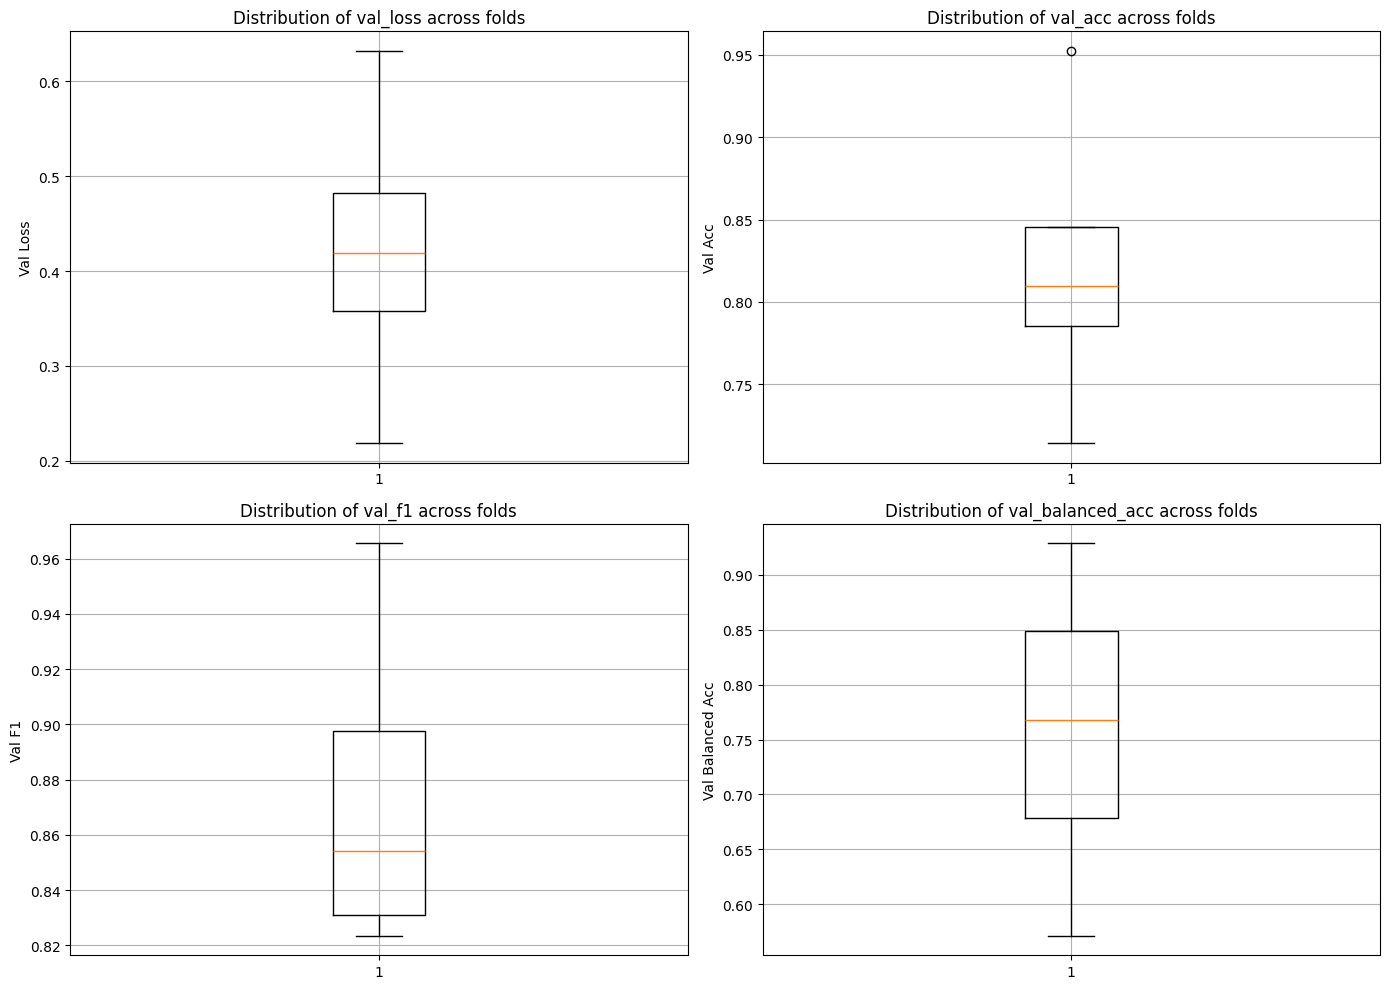

VAL Metrics Summary:
val_loss: mean=0.4219, std=0.1466, min=0.2186, max=0.6320
val_acc: mean=0.8214, std=0.0850, min=0.7143, max=0.9524
val_f1: mean=0.8743, std=0.0561, min=0.8235, max=0.9655
val_balanced_acc: mean=0.7591, std=0.1322, min=0.5714, max=0.9286


In [18]:
# -------------------------------------------------------------------------
# STEP 3: Set up the KFold splitting on the training data
# -------------------------------------------------------------------------
skf = StratifiedKFold(
    n_splits=cfg.data_splitting["num_folds"],
    shuffle=True,
    random_state=cfg.data_splitting["random_seed"]
)

# -------------------------------------------------------------------------
# STEP 5: Cross-Validation Loop (oversampling inside each fold)
# -------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fold_results = []

for fold_idx, (train_index, val_index) in enumerate(skf.split(train_images_paths_np, train_true_labels_np)):
    print(f"\n===== FOLD {fold_idx+1} / {cfg.data_splitting['num_folds']} =====")

    # 5.1 - Subset for this fold
    X_train_fold, X_val_fold = train_images_paths_np[train_index], train_images_paths_np[val_index]
    y_train_fold, y_val_fold = train_true_labels_np[train_index], train_true_labels_np[val_index]
    print(f" starting train samples: {len(X_train_fold)} | val samples: {len(X_val_fold)}")

    cfg.data_loading["batch_size"]=len(X_train_fold)
    print(f"batch size: {cfg.data_loading['batch_size']}")
    if cfg.training["oversample"]:
        X_train_fold_bal, y_train_fold_bal = oversample_minority(
            X_train_fold,
            y_train_fold,
            minority_class_label= minority_label,
            random_seed=cfg.data_splitting["random_seed"]
        )
        print(f" After oversampling  => train samples: {len(X_train_fold_bal)} | val samples: {len(X_val_fold)}")

    elif cfg.training["undersample"]:
        X_train_fold_bal, y_train_fold_bal = undersample_majority(
            X_train_fold,
            y_train_fold,
            minority_class_label= minority_label,
            random_seed=cfg.data_splitting["random_seed"]
        )
        print(f" After undersampling  => train samples: {len(X_train_fold_bal)} | val samples: {len(X_val_fold)}")

    # 5.3 - Create MONAI Datasets and DataLoaders
    if cfg.training["oversample"] or cfg.training["undersample"]:
        train_data = [{"image": img, "label": lbl} for img, lbl in zip(X_train_fold_bal, y_train_fold_bal)]
        val_data = [{"image": img, "label": lbl} for img, lbl in zip(X_val_fold, y_val_fold)]
    else:
        train_data = [{"image": img, "label": lbl} for img, lbl in zip(X_train_fold, y_train_fold)]
        val_data = [{"image": img, "label": lbl} for img, lbl in zip(X_val_fold, y_val_fold)]

    train_dataset = Dataset(data=train_data, transform=train_transforms)
    val_dataset_no_transforms = Dataset(data=val_data)
    val_dataset = Dataset(data=val_data, transform=val_transforms)

    train_loader = DataLoader(train_dataset,
                            batch_size=cfg.data_loading["batch_size"],
                            shuffle=True,
                            num_workers=cfg.data_loading["num_workers"])
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.data_loading["batch_size"],
                            shuffle=False,
                            num_workers=cfg.data_loading["num_workers"])

    val_loader_no_transforms = DataLoader(val_dataset_no_transforms,
                                        batch_size=cfg.data_loading["batch_size"],
                                        shuffle=False,
                                        num_workers=cfg.data_loading["num_workers"])

    # 5.4 - Define model, loss, optimizer for each fold
    model = ViT(
        in_channels=3,
        img_size=(224, 224),
        patch_size=(32, 32),
        hidden_size=128,
        mlp_dim=256,
        num_layers=4,
        num_heads=4,  # Note: you had 4 heads before; adjust as desired.
        proj_type='conv',
        pos_embed_type='learnable',
        classification=True,
        save_attn=True,   # Enable saving attention weights!
        spatial_dims=2
    )
    
    
    # Re-initialize the classifier with smaller weights
    # Proper initialization for classification head
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    # Apply to final classification layer
    model.classification_head.apply(init_weights)
    model.to(device)

    if cfg.training["transfer_learning"] or cfg.training["fine_tuning"]:
        # for param in model.features.parameters():
        #     param.requires_grad = False
        freeze_layers_up_to(model,cfg)

    print_model_summary(model)

    # Use the weights in CrossEntropyLoss
    if cfg.training["weighted_loss"]:
        print("Using weighted loss")
        if 'y_train_fold_bal' in locals():
            raise AssertionError("usless to use weighted loss when oversampling/undersampling is enabled. class are already balanced")
        unique_labels = np.unique(y_train_fold)  # [0, 1]
        #calculate class weights using sklearn
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=y_train_fold
        )
        #Convert them to a tensor, matching CrossEntropyLoss's expected device
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        loss_function = nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_function = nn.CrossEntropyLoss()
    nn.CrossEntropyLoss(

        label_smoothing=0.1  # Critical for small datasets
    )
    #optimizer = optim.Adam(model.parameters(), lr=cfg.training["learning_rate"])
    # All parameters will be sent to the optimizer
    # but the frozen parameters have requires_grad=False, so they won’t update
    cfg.optimizer["learning_rate"] = 1e-3
    print(f"learning rate: {cfg.optimizer['learning_rate']}")

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr = cfg.optimizer["learning_rate"],
        weight_decay = float(cfg.optimizer["weight_decay"])
    )
    from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

    # Replace current scheduler with:
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0= 9,  # Reset every 10 epochs
        T_mult=1,
        eta_min=1e-5  # Minimum LR
    )

    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_balanced_accuracies = []
    val_f1_scores = []

    # 5.5 - Training loop
    for epoch in range(cfg.training["num_epochs"]):
        current_lr = optimizer.param_groups[0]['lr']

        if cfg.training["mixup_alpha"] > 0:
            print("Training with Mixup")
            train_loss, train_acc = train_epoch_mixUp(
                model,
                loader=train_loader,
                optimizer=optimizer,
                loss_function=loss_function,
                device=device,
                mixup_alpha= 0# cfg.training["mixup_alpha"],  #if 0 then no Mixup
            )
        else:
            train_loss, train_acc = train_epoch_vit(model, train_loader, optimizer, loss_function, device)

        val_loss, val_acc, val_f1, val_balanced_acc = val_epoch_vit(model, val_loader, loss_function, device)
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        val_balanced_accuracies.append(val_balanced_acc)  # Add this line

        print(f" Epoch {epoch+1}/{cfg.training['num_epochs']}: "  # Added LR printing
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
          f"Val F1: {val_f1:.4f}, Val Balanced Acc: {val_balanced_acc:.4f}, "
          f"lr: {current_lr:.5f}, "
          )

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save best(model with smallest loss) model for this fold
            torch.save(model.state_dict(), f'best_model_fold_{fold_idx}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == cfg.training["early_stopping_patience"]:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break


    # 5.6 - Load best fold model and get final val performance
    model.load_state_dict(torch.load(f'best_model_fold_{fold_idx}.pth'))

    # Evaluate final performance on the validation split
    final_val_loss, final_val_acc, final_val_f1, final_val_balanced_acc = val_epoch_vit(model, val_loader, loss_function, device)
    print(f"  [FOLD {fold_idx+1} FINAL] Val Loss: {final_val_loss:.4f} | "
        f"Val Acc: {final_val_acc:.4f} | Val F1: {final_val_f1:.4f} | "
        f"Val Balanced Acc: {final_val_balanced_acc:.4f}")

    # store fold results
    fold_results.append({
        "fold": fold_idx+1,
        "val_loss": final_val_loss,
        "val_acc": final_val_acc,
        "val_f1": final_val_f1,
        "val_balanced_acc": final_val_balanced_acc
    })

# -------------------------------------------------------------------------
# STEP 5: Analyze cross-validation results of the best model outside the fold loop
# -------------------------------------------------------------------------

print("\nCross-validation results:")
for res in fold_results:
    print(f"  Fold {res['fold']}: Val Loss = {res['val_loss']:.4f}, "
      f"Val Acc = {res['val_acc']:.4f}, Val F1 = {res['val_f1']:.4f}, "
      f"Val Balanced Acc = {res['val_balanced_acc']:.4f}, "
    )


# Calculate mean metrics
mean_val_acc = np.mean([r["val_acc"] for r in fold_results])
mean_val_loss = np.mean([r["val_loss"] for r in fold_results])
mean_val_f1 = np.mean([r["val_f1"] for r in fold_results])
mean_val_balanced_acc = np.mean([r["val_balanced_acc"] for r in fold_results])

print(f"\nMean Val Loss across folds: {mean_val_loss:.4f}")
print(f"Mean Val Acc across folds: {mean_val_acc:.4f}")
print(f"Mean Val F1 across folds: {mean_val_f1:.4f}")
print(f"Mean Val Balanced Acc across folds: {mean_val_balanced_acc:.4f}")
print("\n")
fig = plot_cv_results(fold_results)

## inner K-fold cv with lr hypoer parameter tuning

In [ ]:
cfg.set_freezed_layer_index(None)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import optuna
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Outer folds using your config setting for number of folds
outer_skf = StratifiedKFold(
    n_splits=cfg.data_splitting["num_folds"],
    shuffle=True,
    random_state=cfg.data_splitting["random_seed"]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = []

# Number of inner folds (default to 3 if not provided)
num_inner_folds = cfg.data_splitting.get("num_inner_folds", 3)

# Number of Optuna trials for tuning the learning rate
n_trials = 5

# If you need a specific minority label for oversampling:
minority_label = minority_label
print("unique labels", np.unique(labels_np))

for fold_idx, (train_index, test_index) in enumerate(outer_skf.split(images_paths_np, labels_np)):
    print(f"\n===== OUTER FOLD {fold_idx+1} / {cfg.data_splitting['num_folds']} =====")

    # -------------------------------------------------------
    # 1) Outer train/test split (held-out test for final only)
    # -------------------------------------------------------
    X_train_outer = images_paths_np[train_index]
    y_train_outer = labels_np[train_index]

    X_test_outer = images_paths_np[test_index]
    y_test_outer = labels_np[test_index]
    
    outer_train_size = len(X_train_outer)
    outer_test_size = len(X_test_outer)
    
    print(f" Outer Train samples: {outer_train_size} | Outer Test samples: {outer_test_size}")

    # =======================================================
    # 2) Inner CV with Optuna to tune the learning rate
    # =======================================================
    def objective(trial):
        """
        For a candidate LR from trial.suggest_float(...),
        do an inner StratifiedKFold on X_train_outer, y_train_outer
        to compute average val loss. We'll minimize that average.
        """
        candidate_lr = trial.suggest_float("lr", 8e-6, 7e-4, log=True)

        inner_skf = StratifiedKFold(
            n_splits=num_inner_folds,
            shuffle=True,
            random_state=cfg.data_splitting["random_seed"]
        )

        inner_val_losses = []

        for inner_train_idx, inner_val_idx in inner_skf.split(X_train_outer, y_train_outer):
            # Subset for this inner fold
            X_train_inner = X_train_outer[inner_train_idx]
            y_train_inner = y_train_outer[inner_train_idx]

            X_val_inner = X_train_outer[inner_val_idx]
            y_val_inner = y_train_outer[inner_val_idx]

            # Oversample or undersample if needed
            if cfg.training["oversample"]:
                X_train_inner_bal, y_train_inner_bal = oversample_minority(
                    X_train_inner, y_train_inner,
                    minority_class_label=minority_label,
                    random_seed=cfg.data_splitting["random_seed"]
                )
            elif cfg.training["undersample"]:
                X_train_inner_bal, y_train_inner_bal = undersample_majority(
                    X_train_inner, y_train_inner,
                    minority_class_label=minority_label,
                    random_seed=cfg.data_splitting["random_seed"]
                )
            else:
                X_train_inner_bal, y_train_inner_bal = X_train_inner, y_train_inner

            # Create MONAI Datasets and DataLoaders
            train_data_inner = [
                {"image": img, "label": lbl}
                for img, lbl in zip(X_train_inner_bal, y_train_inner_bal)
            ]
            val_data_inner = [
                {"image": img, "label": lbl}
                for img, lbl in zip(X_val_inner, y_val_inner)
            ]

            train_dataset_inner = Dataset(data=train_data_inner, transform=train_transforms)
            val_dataset_inner   = Dataset(data=val_data_inner,   transform=val_transforms)

            train_loader_inner = DataLoader(
                train_dataset_inner,
                batch_size=cfg.data_loading["batch_size"],
                shuffle=True,
                num_workers=cfg.data_loading["num_workers"]
            )
            val_loader_inner = DataLoader(
                val_dataset_inner,
                batch_size=cfg.data_loading["batch_size"],
                shuffle=False,
                num_workers=cfg.data_loading["num_workers"]
            )

            # Build ViT model for this trial
            model_inner, device_inner = setup_model(cfg)
            if cfg.training["transfer_learning"] or cfg.training["fine_tuning"]:
                freeze_layers_up_to(model_inner, cfg)

            # Weighted loss if needed
            if (cfg.training["weighted_loss"] and 
                not (cfg.training["oversample"] or cfg.training["undersample"])):
                unique_labels_inner = np.unique(y_train_inner)
                class_weights = compute_class_weight(
                    class_weight='balanced',
                    classes=unique_labels_inner,
                    y=y_train_inner
                )
                class_weights = torch.tensor(class_weights, dtype=torch.float).to(device_inner)
                loss_function_inner = nn.CrossEntropyLoss(weight=class_weights)
            else:
                loss_function_inner = nn.CrossEntropyLoss()

            # Create optimizer with the candidate LR
            optimizer_inner = optim.Adam(
                filter(lambda p: p.requires_grad, model_inner.parameters()),
                lr=candidate_lr,
                weight_decay=float(cfg.optimizer["weight_decay"])
            )

            # Use fewer epochs in inner tuning
            inner_num_epochs = 4
            print("number of inner epochs used for hyper-param tuning: ", inner_num_epochs)
            best_inner_loss = float("inf")

            for ep in range(inner_num_epochs):
                # ViT-specific training
                tr_loss, tr_acc = train_epoch_vit(
                    model_inner, train_loader_inner, 
                    optimizer_inner, loss_function_inner, device_inner
                )
                val_loss_inner, val_acc_inner, val_f1_inner, val_bal_inner = val_epoch_vit(
                    model_inner, val_loader_inner, loss_function_inner, device_inner
                )
                if val_loss_inner < best_inner_loss:
                    best_inner_loss = val_loss_inner

            # Collect the best val loss from this inner fold
            inner_val_losses.append(best_inner_loss)

        # Return the average inner validation loss
        return float(np.mean(inner_val_losses))

    # Create the Optuna study and optimize
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_lr = study.best_params["lr"]
    print(f"  [OUTER FOLD {fold_idx+1}] Best LR from inner CV = {best_lr:.6f}")

    # ==================================================================
    # 3) Final Training on Outer Train (with a small hold-out for ES),
    #    never touching the outer test set until final evaluation
    # ==================================================================

    # --- 3a) First split out a small fraction for early stopping, 
    #         *before* oversampling that portion.
    #val_fraction =   # e.g., 0.2
    X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
        X_train_outer,
        y_train_outer,
        test_size=cfg.data_splitting["val_set_size"],
        stratify=y_train_outer,
        random_state=cfg.data_splitting["random_seed"]
    )

    # Now oversample *only* the training portion 
    if cfg.training["oversample"]:
        X_train_es_bal, y_train_es_bal = oversample_minority(
            X_train_es, 
            y_train_es,
            minority_class_label=minority_label,
            random_seed=cfg.data_splitting["random_seed"]
        )
    elif cfg.training["undersample"]:
        X_train_es_bal, y_train_es_bal = undersample_majority(
            X_train_es, 
            y_train_es,
            minority_class_label=minority_label,
            random_seed=cfg.data_splitting["random_seed"]
        )
    else:
        X_train_es_bal, y_train_es_bal = X_train_es, y_train_es

    print(f" Early-stop train size (post over/undersampling): {len(X_train_es_bal)}")
    print(f" Early-stop val size (original distribution): {len(X_val_es)}")
     
    internal_train_size = len(X_train_es_bal)
    internal_val_size = len(X_val_es) 
    print(f"Train samples for es: {internal_train_size}, Val samples for es: {internal_val_size}")

    # Build Datasets for final training & ES validation
    train_data_es = [
        {"image": img, "label": lbl}
        for img, lbl in zip(X_train_es_bal, y_train_es_bal)
    ]
    val_data_es   = [
        {"image": img, "label": lbl}
        for img, lbl in zip(X_val_es, y_val_es)
    ]

    train_dataset_es = Dataset(data=train_data_es, transform=train_transforms)
    val_dataset_es   = Dataset(data=val_data_es,   transform=val_transforms)

    train_loader_es = DataLoader(
        train_dataset_es,
        batch_size=cfg.data_loading["batch_size"],
        shuffle=True,
        num_workers=cfg.data_loading["num_workers"]
    )
    val_loader_es = DataLoader(
        val_dataset_es,
        batch_size=cfg.data_loading["batch_size"],
        shuffle=False,
        num_workers=cfg.data_loading["num_workers"]
    )

    # --- 3b) Outer test set is never touched until after training finishes
    test_data = [
        {"image": img, "label": lbl}
        for img, lbl in zip(X_test_outer, y_test_outer)
    ]
    test_dataset = Dataset(data=test_data, transform=val_transforms)
    test_loader  = DataLoader(
        test_dataset,
        batch_size=cfg.data_loading["batch_size"],
        shuffle=False,
        num_workers=cfg.data_loading["num_workers"]
    )

    # Build a new ViT model for final outer training
    model, device = setup_model(cfg)
    if cfg.training["transfer_learning"] or cfg.training["fine_tuning"]:
        freeze_layers_up_to(model, cfg)

    print_model_summary(model)

    # Weighted loss check
    if (cfg.training["weighted_loss"] and 
        not (cfg.training["oversample"] or cfg.training["undersample"])):
        # Weighted loss uses outer train distribution
        unique_labels_outer = np.unique(y_train_outer)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_labels_outer,
            y=y_train_outer
        )
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        loss_function = nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_function = nn.CrossEntropyLoss()

    print(f"learning rate (from inner CV best) = {best_lr}")
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=best_lr,
        weight_decay=float(cfg.optimizer["weight_decay"])
    )
    # CosineAnnealingWarmRestarts scheduler
    scheduler = CosineAnnealingWarmRestarts(
        optimizer,
        T_0=5,      # e.g., reset cycle every 5 epochs
        T_mult=2,
        eta_min=5e-6
    )

    # -------------------------------------------------------
    # 4) Training loop with early stopping on val_loader_es
    # -------------------------------------------------------
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_balanced_accuracies = []
    val_f1_scores = []

    for epoch in range(cfg.training["num_epochs"]):
        current_lr = optimizer.param_groups[0]['lr']

        # Possibly do Mixup
        if cfg.training["mixup_alpha"] > 0:
            print("Training with Mixup")
            train_loss, train_acc = train_epoch_mixUp(
                model,
                loader=train_loader_es,
                optimizer=optimizer,
                loss_function=loss_function,
                device=device,
                mixup_alpha=cfg.training["mixup_alpha"]
            )
        else:
            train_loss, train_acc = train_epoch_vit(
                model, train_loader_es, optimizer, loss_function, device
            )

        # Evaluate on the early-stopping validation set
        val_loss, val_acc, val_f1, val_balanced_acc = val_epoch_vit(
            model, val_loader_es, loss_function, device
        )

        # Step the scheduler if desired
        scheduler.step(epoch + 1)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)
        val_balanced_accuracies.append(val_balanced_acc)

        print(f" Epoch {epoch+1}/{cfg.training['num_epochs']}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Val F1: {val_f1:.4f}, Val Balanced Acc: {val_balanced_acc:.4f}, "
              f"lr: {current_lr:.5f}")

        # Early stopping on internal validation
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold_idx}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == cfg.training["early_stopping_patience"]:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # -------------------------------------------------------
    # 5) Evaluate on outer test set (untouched till now)
    # -------------------------------------------------------
    model.load_state_dict(torch.load(f'best_model_fold_{fold_idx}.pth'))

    final_test_loss, final_test_acc, final_test_f1, final_test_balanced_acc = val_epoch_vit(
        model, test_loader, loss_function, device
    )
    print(f"  [FOLD {fold_idx+1} FINAL] Test Loss: {final_test_loss:.4f} | "
          f"Test Acc: {final_test_acc:.4f} | Test F1: {final_test_f1:.4f} | "
          f"Test Balanced Acc: {final_test_balanced_acc:.4f}")

    # Store fold results
    fold_results.append({
        "fold": fold_idx+1,
        "test_loss": final_test_loss,
        "test_acc": final_test_acc,
        "test_f1": final_test_f1,
        "test_balanced_acc": final_test_balanced_acc,
        "best_lr": best_lr
    })

# -------------------------------------------------------------------------
# 6) Analyze cross-validation results after all outer folds
# -------------------------------------------------------------------------
print("-------------------------------------------------")
print("\nCross-validation results (outer folds):")
for res in fold_results:
    print(f"  Fold {res['fold']}: "
          f"Test Loss = {res['test_loss']:.4f}, "
          f"Test Acc = {res['test_acc']:.4f}, "
          f"Test F1 = {res['test_f1']:.4f}, "
          f"Test Balanced Acc = {res['test_balanced_acc']:.4f}, "
          f"(Best LR={res['best_lr']:.6f})")

mean_test_acc = np.mean([r["test_acc"] for r in fold_results])
mean_test_loss = np.mean([r["test_loss"] for r in fold_results])
mean_test_f1 = np.mean([r["test_f1"] for r in fold_results])
mean_test_balanced_acc = np.mean([r["test_balanced_acc"] for r in fold_results])

print(f"\nMean Test Loss across outer folds: {mean_test_loss:.4f}")
print(f"Mean Test Acc across outer folds: {mean_test_acc:.4f}")
print(f"Mean Test F1 across outer folds: {mean_test_f1:.4f}")
print(f"Mean Test Balanced Acc across outer folds: {mean_test_balanced_acc:.4f}")

from utils.data_visualization_functions import generate_cv_results_figure
fold_box_plot_fig = generate_cv_results_figure(fold_results, 'test')
plt.show()  # If you have a plotting function

hold_out_cv = True
# cfg.set_freezed_layer_index(None)  # Reset if needed


## test set evaluation

In [14]:
from utils.test_functions import (
    evaluate_model, plot_confusion_matrix,
    show_misclassified_images,
    plot_roc_curve,
    )


Evaluation Results:

Test Set Metrics:
Accuracy: 0.7000
F1 Score: 0.5714
Balanced Accuracy: 0.7000
Mean Confidence: 0.5633

Found 3 misclassified samples:
True: 1, Pred: 0, Conf: 0.51
True: 1, Pred: 0, Conf: 0.51
True: 1, Pred: 0, Conf: 0.52


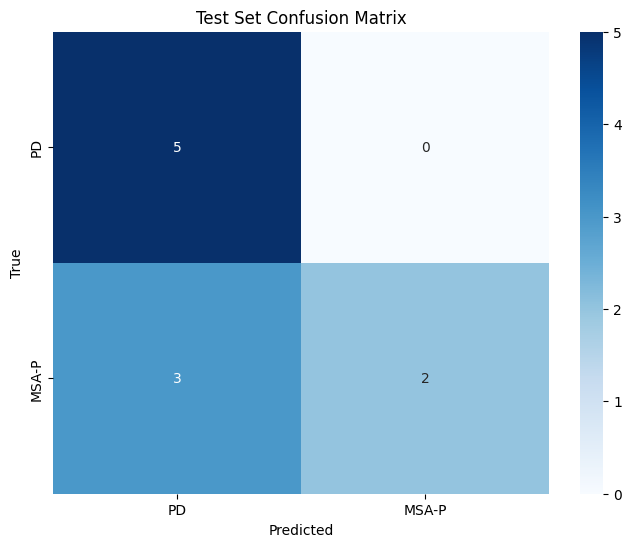

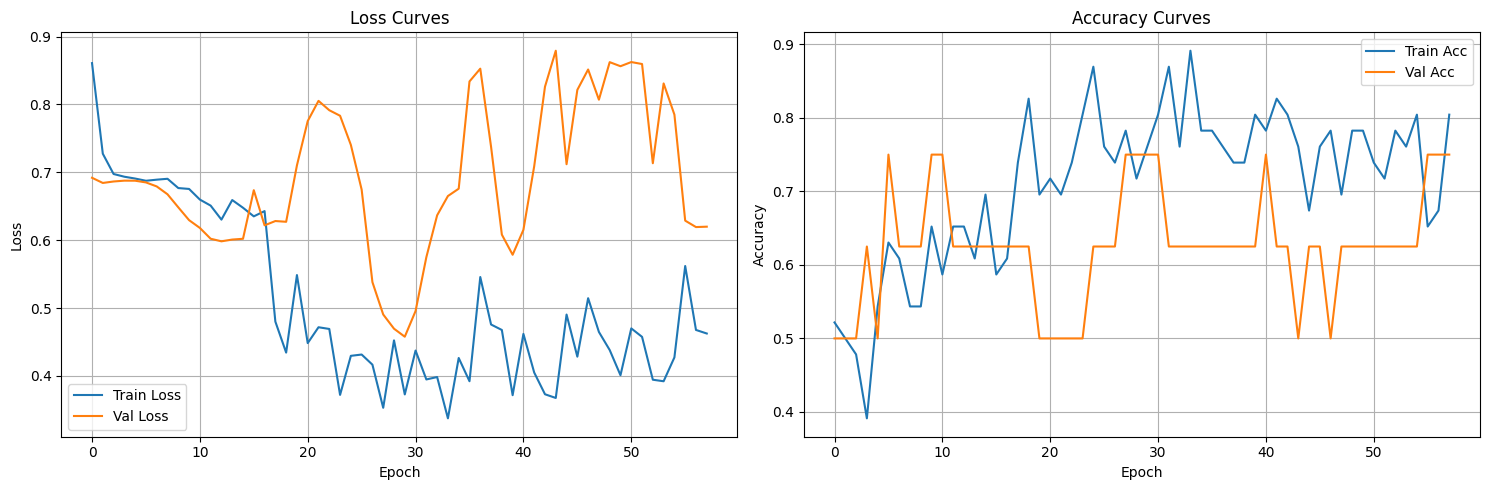

In [28]:
# # Load best model
if fold_results:
    best_fold_idx = np.argmax([r["test_acc"] for r in fold_results])
    best_model_path = f"best_model_fold_{best_fold_idx}.pth"
    model.load_state_dict(torch.load(best_model_path))

# # create test dataset and loader

# #true_test_labels = 1 - true_test_labels
# test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, true_test_labels)]
# test_dataset = Dataset(data=test_data, transform=test_transforms)
# test_loader = DataLoader(test_dataset, batch_size=cfg.data_loading["batch_size"], shuffle=False, num_workers=cfg.data_loading["num_workers"])

# results on test set
#final_val_loss, final_val_acc, final_val_f1, final_val_balanced_acc = val_epoch_vit(model, test_loader, loss_function, device)
# Run evaluation
from utils.test_functions import (
    evaluate_model, plot_confusion_matrix,
    show_misclassified_images,
    plot_roc_curve,
    calculate_classification_metrics
    )

def evaluate_model_vit(model, dataloader, class_names, device=None, return_misclassified=False):
    """
    Comprehensive model evaluation specifically designed for Vision Transformer models.

    Inputs:
    - model (torch.nn.Module): The Vision Transformer PyTorch model to evaluate.
    - dataloader (torch.utils.data.DataLoader): DataLoader providing batches of images and labels.
    - class_names (list of str): List of class names for detailed classification metrics.
    - device (torch.device, optional): Device to perform computations on (CPU/GPU).
    - return_misclassified (bool, optional): Whether to include misclassified samples in the results.

    Returns:
    - results (dict): Contains predictions, true labels, confidences, metrics, and optionally misclassified samples.
    """
    # Determine computation device (GPU if available)
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # Move model to target device

    # Initialize storage containers
    results = {
        'predictions': [],    # Model's predicted class indices
        'true_labels': [],    # Ground truth labels
        'confidences': [],    # Confidence scores for predictions
        'misclassified': []   # Stores problematic cases if requested
    }

    # Set model to evaluation mode (disables dropout/batchnorm)
    model.eval()

    # Disable gradient calculation for faster inference
    with torch.no_grad():
        # Process data in batches to save memory
        for batch_idx, batch in enumerate(dataloader):
            # Move data to target device
            images = batch["image"].to(device)
            labels = batch["label"].to(device).long()  # Ensure labels are integers

            # Forward pass through model - Vision Transformer specific
            outputs, hidden_states = model(images)
            
            # Extract logits - ensures we're working with just the classification tensor
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Take first element if outputs is still a tuple
            else:
                logits = outputs
                
            # Convert logits to probabilities using softmax
            probs = torch.softmax(logits, dim=1)

            # Get confidence scores and predicted class indices
            confs, preds = torch.max(probs, dim=1)

            # Move data back to CPU and convert to numpy
            preds_np = preds.cpu().numpy()
            labels_np = labels.cpu().numpy()
            confs_np = confs.cpu().numpy()

            # Store batch results
            results['predictions'].extend(preds_np)
            results['true_labels'].extend(labels_np)
            results['confidences'].extend(confs_np)

            # Optional: Capture misclassified samples for analysis
            if return_misclassified:
                # Create boolean mask of incorrect predictions
                mask = preds_np != labels_np

                # Collect details for misclassified samples
                misclassified = [{
                    'image': images[i].cpu().numpy(),  # Original image data
                    'true_label': labels_np[i],        # Actual class
                    'pred_label': preds_np[i],         # Model's prediction
                    'confidence': confs_np[i],         # How confident was the model
                    'batch_idx': batch_idx             # For debugging batches
                } for i in np.where(mask)[0]]  # np.where(mask)[0] gets indices of True values

                results['misclassified'].extend(misclassified)

    # Convert lists to numpy arrays for easier analysis
    for key in ['predictions', 'true_labels', 'confidences']:
        results[key] = np.array(results[key])

    # Calculate performance metrics
    results['metrics'] = calculate_classification_metrics(
        results['true_labels'],
        results['predictions'],
        confidences=results['confidences'],
        class_names=class_names
    )

    # Return appropriate data based on request
    return results if return_misclassified else {k:v for k,v in results.items() if k != 'misclassified'}

eval_results = evaluate_model_vit(
    model=model,
    dataloader = test_loader,
    class_names=[class0_name, class1_name],
    return_misclassified=True
)

print("\nEvaluation Results:")
#print(eval_results)

# Print metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {eval_results['metrics']['accuracy']:.4f}")
print(f"F1 Score: {eval_results['metrics']['f1']:.4f}")
print(f"Balanced Accuracy: {eval_results['metrics']['balanced_accuracy']:.4f}")
print(f"Mean Confidence: {eval_results['metrics']['mean_confidence']:.4f}")

confusion_matrix_fig = plot_confusion_matrix(
    eval_results['metrics']['confusion_matrix'],
    class_names=[class0_name, class1_name],
    title='Test Set Confusion Matrix'
)
confusion_matrix_fig

# Analyze misclassified samples (example)
if 'misclassified' in eval_results:
    print(f"\nFound {len(eval_results['misclassified'])} misclassified samples:")
    for sample in eval_results['misclassified'][:3]:  # Show first 3
        print(f"True: {sample['true_label']}, Pred: {sample['pred_label']}, Conf: {sample['confidence']:.2f}")

from utils.data_visualization_functions import plot_learning_curves

# Plot learning curves
fig_learning_curves = plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

dict_keys(['image', 'true_label', 'pred_label', 'confidence', 'batch_idx'])


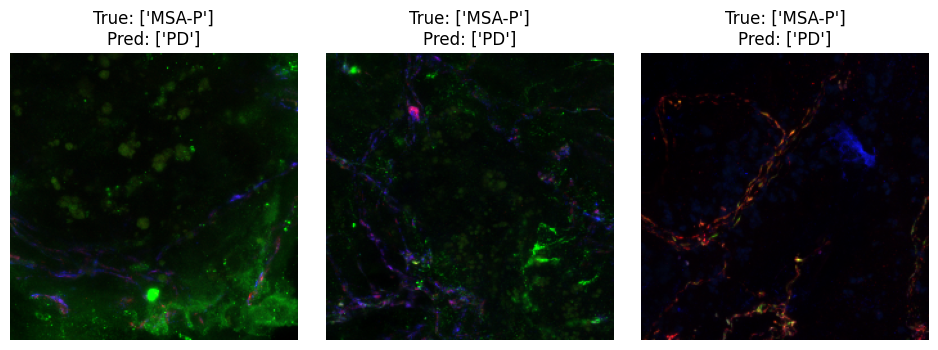

Number of misclassified images: 3
Image shape: (3, 224, 224)


In [29]:
# Display misclassified images
show_misclassified_images(
    misclassified_images=eval_results["misclassified"],
    num_images=len(eval_results["misclassified"]),
    normalize=True,
    class1_name=class1_name,
    class0_name=class0_name
)
#eval_results["misclassified"] is a list of dictionaries 
# [{
#     'image': array(...),  # NumPy array with shape (3, H, W) representing RGB image data
#     'true_label': int,    # Ground truth label (0 or 1)
#     'pred_label': int,    # Predicted label (0 or 1)
#     'confidence': float,  # Prediction confidence score
#     'batch_idx': int     # Batch index
# }, ....]

misclassified_images = [sample["image"] for sample in eval_results["misclassified"]]
misclassified_true_labels = [sample["true_label"] for sample in eval_results["misclassified"]]
misclassified_pred_labels = [sample["pred_label"] for sample in eval_results["misclassified"]]

# Report on misclassified images
print(f"Number of misclassified images: {len(misclassified_images)}")

# Only try to access shapes if we have misclassified images
if misclassified_images:
    print("Image shape:", misclassified_images[0].shape)
    # Add any additional analysis of misclassified images here
else:
    print("No misclassified images found! Perfect classification.")

In [17]:
from utils.directory_functions import get_tracking_uri,get_base_directory, get_data_directory
from utils.test_functions import evaluate_model, plot_confusion_matrix, show_misclassified_images, plot_roc_curve

In [32]:
tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)

print(f"Current tracking uri: {tracking_uri}")
print(cfg.get_freezed_layer_index())
# Start your components list with the model name
model_name = model.__class__.__name__
components = [model_name]

if cfg.training["mixup_alpha"] > 0:
    components.append(f"mixup{cfg.training['mixup_alpha']}")

if cfg.training["oversample"]:
    components.append("oversamp")

if cfg.training["undersample"]:
    components.append("undersamp")

if cfg.training["weighted_loss"]:
    components.append("weighted")

if cfg.training["fine_tuning"]:
    components.append("FT")

if cfg.training["transfer_learning"]:
    components.append("TL")

if cfg.training["pretrained"]:
    components.append("pretrained")

if cfg.get_freezed_layer_index() is not None:
    components.append(f"freeze{cfg.get_freezed_layer_index()}")

run_name = "_".join(components)
run_name = run_name + "_oversample_fixed"
print("Run name:", run_name)
print_layers(model)
#print("experiment_name:",experiment_name)


you are on linux
Current tracking uri: /home/zano/Documents/TESI/mlruns
None
Run name: ViT_oversamp_oversample_fixed

patch_embedding
patch_embedding.patch_embeddings
patch_embedding.dropout
blocks
blocks.0
blocks.0.mlp
blocks.0.mlp.linear1
blocks.0.mlp.linear2
blocks.0.mlp.fn
blocks.0.mlp.drop1
blocks.0.mlp.drop2
blocks.0.norm1
blocks.0.attn
blocks.0.attn.out_proj
blocks.0.attn.qkv
blocks.0.attn.to_q
blocks.0.attn.input_rearrange
blocks.0.attn.out_rearrange
blocks.0.attn.drop_output
blocks.0.attn.drop_weights
blocks.0.norm2
blocks.0.norm_cross_attn
blocks.0.cross_attn
blocks.0.cross_attn.out_proj
blocks.0.cross_attn.to_q
blocks.0.cross_attn.to_k
blocks.0.cross_attn.to_v
blocks.0.cross_attn.input_rearrange
blocks.0.cross_attn.out_rearrange
blocks.0.cross_attn.drop_output
blocks.0.cross_attn.drop_weights
blocks.1
blocks.1.mlp
blocks.1.mlp.linear1
blocks.1.mlp.linear2
blocks.1.mlp.fn
blocks.1.mlp.drop1
blocks.1.mlp.drop2
blocks.1.norm1
blocks.1.attn
blocks.1.attn.out_proj
blocks.1.attn.q

In [33]:
# Gather attention matrices from each block.
# Each attention matrix should have shape: [B, num_heads, tokens, tokens]
attentions = []
for blk in model.blocks:
    # blk.attn is the SABlock instance; if save_attn is True, it stores the attention in att_mat.
    attn = blk.attn.att_mat  # This is a tensor with shape [B, num_heads, tokens, tokens]
    attentions.append(attn)
# -------------------------------------------------------------------------
# Helper: Attention Rollout Function
# -------------------------------------------------------------------------
def compute_rollout(attentions):
    """
    Computes the aggregated (rolled out) attention across layers.
    
    Args:
        attentions (list of torch.Tensor): Each tensor is [B, num_heads, tokens, tokens].
        
    Returns:
        torch.Tensor: Rolled out attention with shape [B, tokens, tokens].
    """
    rollout = None
    for attn in attentions:
        # Average attention over heads -> [B, tokens, tokens]
        attn_heads_fused = attn.mean(dim=1)
        B, N, _ = attn_heads_fused.shape
        # Add the identity matrix to account for residual connections.
        identity = torch.eye(N, device=attn_heads_fused.device).unsqueeze(0).expand(B, -1, -1)
        attn_heads_fused = attn_heads_fused + identity
        # Renormalize each row
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        # Multiply the attentions: each layer’s attention is combined multiplicatively.
        if rollout is None:
            rollout = attn_heads_fused
        else:
            rollout = torch.matmul(attn_heads_fused, rollout)
    return rollout

# -------------------------------------------------------------------------
# STEP 6: Evaluate on Test Set and Generate Interpretability Overlays
# -------------------------------------------------------------------------

# 6.1 - Create the test Dataset and DataLoader
test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_labels)]
test_transforms = val_transforms  # your validation/test transforms
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)
output_path = "./attention_overlays"  # Folder to save overlays

def save_attention_overlays_from_loader(test_loader, model, output_path, device):
    """
    Generates and saves attention rollout overlay images from a given DataLoader.

    Args:
        loader (DataLoader): A pre-built DataLoader yielding batches with keys "image" and "label".
        model (torch.nn.Module): The trained ViT model.
        output_path (str): Folder where overlay images will be saved.
        device (torch.device): Device on which the model runs.
        cfg: Configuration object/dictionary with data_loading settings.
    """
    import os
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    from utils.data_visualization_functions import min_max_normalization, imageNet_denormalize

    os.makedirs(output_path, exist_ok=True)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images_batch = batch["image"].to(device)          # [B, 3, 224, 224]
            labels_batch = batch["label"].to(device).long()     # [B]

            # Run inference; model returns (outputs, hidden_states)
            outputs, _ = model(images_batch)
            _, predicted = torch.max(outputs, dim=1)

            # Collect attention matrices from each TransformerBlock.
            attentions = [blk.attn.att_mat for blk in model.blocks]  # each: [B, num_heads, tokens, tokens]
            rollout = compute_rollout(attentions)  # shape: [B, tokens, tokens]

            # Convert images and labels to numpy arrays for visualization.
            batch_images_np = images_batch.cpu().numpy()  # shape: [B, C, H, W]
            batch_labels_np = labels_batch.cpu().numpy()
            batch_pred_np = predicted.cpu().numpy()

            # Process each image in the batch individually.
            for i in range(images_batch.size(0)):
                rollout_sample = rollout[i]  # [tokens, tokens]
                # Skip the CLS token: extract attention to patch tokens.
                class_attn = rollout_sample[0, 1:]
                grid_size = int(np.sqrt(class_attn.shape[0]))  # e.g., 7 for a 7x7 grid
                attn_map = class_attn.reshape(grid_size, grid_size)

                # Upsample the attention map to the original image size.
                attn_map_tensor = attn_map.clone().detach().unsqueeze(0).unsqueeze(0)
                attn_map_tensor = F.interpolate(attn_map_tensor, size=(224, 224), mode='bilinear', align_corners=False)
                attn_map_upsampled = attn_map_tensor.squeeze().cpu().numpy()

                # Convert the original image from [C, H, W] to [H, W, C] format.
                orig_img = batch_images_np[i].transpose(1, 2, 0)
                orig_img = imageNet_denormalize(orig_img)
                orig_img = min_max_normalization(orig_img)

                # Normalize the attention map for visualization.
                attn_map_norm = min_max_normalization(attn_map_upsampled)

                # Create an overlay plot.
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(orig_img)
                ax[0].set_title("Original Image")
                ax[0].axis("off")

                ax[1].imshow(orig_img)
                ax[1].imshow(attn_map_norm, cmap="jet", alpha=0.5)
                ax[1].set_title(f"Overlay\nTrue: {batch_labels_np[i]}, Pred: {batch_pred_np[i]}")
                ax[1].axis("off")
                plt.suptitle(f"Batch {batch_idx} - Sample {i}")

                # Save the overlay figure.
                output_filename = os.path.join(output_path, f"overlay_batch{batch_idx}_sample{i}.png")
                fig.savefig(output_filename)
                plt.close(fig)
                
# Call the function to save overlays
#save_attention_overlays_from_loader(test_loader, model, output_path, device)

In [34]:
#target_layer = "features.denseblock4.denselayer32.layers.conv2"  # or use input(...) to prompt
experiment_name = f"{class0_name}_vs_{class1_name}_classifier_test_true_hyp"
mlflow.set_experiment(experiment_name)
with mlflow.start_run(run_name=run_name):

    # Log parameters
    mlflow.log_params(cfg.data_splitting)
    mlflow.log_params(cfg.data_augmentation)
    mlflow.log_params(cfg.data_loading)
    mlflow.log_params(cfg.model)
    mlflow.log_params(cfg.training)
    mlflow.log_params(cfg.optimizer)
    mlflow.log_param("freezed_layer_index", cfg.get_freezed_layer_index())
    mlflow.log_param("num_epochs", cfg.training["num_epochs"])
    mlflow.log_param("early_stopping_patience", cfg.training["early_stopping_patience"])
    mlflow.log_param("mixup_alpha", cfg.training["mixup_alpha"])
    mlflow.log_param("oversample", cfg.training["oversample"])
    mlflow.log_param("undersample", cfg.training["undersample"])
    mlflow.log_param("weighted_loss", cfg.training["weighted_loss"])
    mlflow.log_param("fine_tuning", cfg.training["fine_tuning"])
    mlflow.log_param("transfer_learning", cfg.training["transfer_learning"])
    mlflow.log_param("pretrained", cfg.training["pretrained"])
    mlflow.log_param("weight_decay", cfg.optimizer["weight_decay"])
    mlflow.log_param("outer_test_size", outer_test_size)
    mlflow.log_param("outer_train_size", outer_train_size)
    mlflow.log_param("internal_train_size", internal_train_size)
    mlflow.log_param("internal_val_size", internal_val_size)
    # log learning curves image
    try:
        fig_learning_curves
        if fig_learning_curves is not None:
            mlflow.log_figure(fig_learning_curves, "learning_curves.png")
    except NameError:
        print("No learning curves figure to log")
        
    mlflow.log_figure(fold_box_plot_fig, "fold_box_plots.png")
    
    # Log metrics for each epoch
    for epoch in range(len(train_losses)):
        mlflow.log_metric("train_loss", train_losses[epoch], step=epoch)
        mlflow.log_metric("train_accuracy", train_accuracies[epoch], step=epoch)
        mlflow.log_metric("val_loss", val_losses[epoch], step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracies[epoch], step=epoch)
        mlflow.log_metric("val_f1", val_f1_scores[epoch], step=epoch)
        mlflow.log_metric("val_balanced_accuracy", val_balanced_accuracies[epoch], step=epoch)
    
    # Log final metrics and fold results (if available)
    try:
        fold_results
    except NameError:
        fold_results = None
    if fold_results is not None:
        from utils.mlflow_functions import log_fold_results_metrics
        log_fold_results_metrics(fold_results, prefix='val')
        try:
            if fig is not None:
                mlflow.log_figure(fig, "fold_results.png")
        except NameError:
            print("No fold results figure to log")
    
    try:
        if fig_learning_curves is not None:
            mlflow.log_figure(fig_learning_curves, "learning_curves.png")
    except NameError:
        print("No learning curves figure to log")
    
    # Log the Model
    mlflow.pytorch.log_model(model, "model")
    
    # Log the Notebook
    base_dir = get_base_directory(gdrive, kaggle, linux)
    if gdrive:
        mlflow.log_artifact("/content/drive/MyDrive/TESI/TESI/notebooks/vit_classifier.ipynb")
    elif kaggle:
        print("you are on kaggle skip saving ipynb")
    else:
        mlflow.log_artifact(rf"{base_dir}/notebooks/vit_classifier.ipynb")
    
    print("Model training completed and logged to MLflow.")
    
    # Evaluate on the test set
    test_results = evaluate_model_vit(model, test_loader, class_names=[class0_name, class1_name], return_misclassified=False)
    print("test_results[metrics]", test_results["metrics"])
    avg_test_accuracy = test_results["metrics"]["classification_report"]["accuracy"]
    print(f"Accuracy: {test_results['metrics']['classification_report']['accuracy']:.4f}")
    avg_test_f1 = test_results["metrics"]["f1"]
    avg_test_balanced_acc = test_results["metrics"]["balanced_accuracy"]
    
    # Log test metrics
    mlflow.log_metric("test_accuracy", avg_test_accuracy)
    mlflow.log_metric("test_f1", avg_test_f1)
    mlflow.log_metric("test_balanced_accuracy", avg_test_balanced_acc)
    
    if hold_out_cv:
        mlflow.log_metric("mean_test_accuracy", mean_test_acc)
        mlflow.log_metric("mean_test_f1", mean_test_f1)
        mlflow.log_metric("mean_test_balanced_accuracy", mean_test_balanced_acc)
    
    # Confusion Matrix
    plot_confusion_matrix(
        cm=test_results["metrics"]["confusion_matrix"],
        class_names=[class0_name, class1_name],
        title="Confusion Matrix (Test Set)",
        figsize=(8, 6)
    )
    mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
    plt.close()
    
    #-------------- Log YAML file with all parameters -------------------
    import yaml
    mlflow.log_artifact(yaml_path, "config")
    with open(yaml_path) as f:
        yaml_config = yaml.safe_load(f)
    for section, params in yaml_config.items():
        if isinstance(params, dict):
            mlflow.log_params({f"{section}.{k}": v for k, v in params.items()})
    
    # Log the transformations file
    mlflow.log_artifact("/home/zano/Documents/TESI/TESI/utils/transformations_functions.py", "transform_params")
    
    # -------------- Save Activation Overlays -------------------
    import shutil
    
    all_data = [{"image": img, "label": lbl} for img, lbl in zip(images_paths_np, labels_np)]

    all_dataset = Dataset(data=all_data, transform=train_transforms)
    

    all_data_loader = DataLoader(all_dataset,
                              batch_size=cfg.data_loading["batch_size"],
                              shuffle=True,
                              num_workers=cfg.data_loading["num_workers"])
    
    all_data_activations_loader_path = "activations_overlays_all"
    save_attention_overlays_from_loader(all_data_loader, model, all_data_activations_loader_path, device)
    mlflow.log_artifacts(all_data_activations_loader_path, artifact_path="activation_overlays_all")
    shutil.rmtree(all_data_activations_loader_path)
    
    activation_overlay_output_path = "activation_overlays"
    save_attention_overlays_from_loader(test_loader, model, activation_overlay_output_path, device)
    mlflow.log_artifacts(activation_overlay_output_path, artifact_path="activation_overlays_test")

    # Delete the local directory after logging to MLflow
    shutil.rmtree(activation_overlay_output_path)

    cfg.set_freezed_layer_index(None)  # Reset the frozen layer index if needed

No fold results figure to log


2025/03/06 14:00:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training completed and logged to MLflow.
test_results[metrics] {'accuracy': 0.7142857142857143, 'f1': 0.6666666666666666, 'balanced_accuracy': 0.7083333333333333, 'confusion_matrix': array([[3, 1],
       [1, 2]]), 'mean_confidence': 0.5587087, 'confidence_histogram': array([0, 0, 0, 0, 0, 6, 0, 0, 1, 0]), 'classification_report': {'PD': {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 4.0}, 'MSA-P': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 3.0}, 'accuracy': 0.7142857142857143, 'macro avg': {'precision': 0.7083333333333333, 'recall': 0.7083333333333333, 'f1-score': 0.7083333333333333, 'support': 7.0}, 'weighted avg': {'precision': 0.7142857142857143, 'recall': 0.7142857142857143, 'f1-score': 0.7142857142857143, 'support': 7.0}}}
Accuracy: 0.7143


## visualize mlflow ui locally

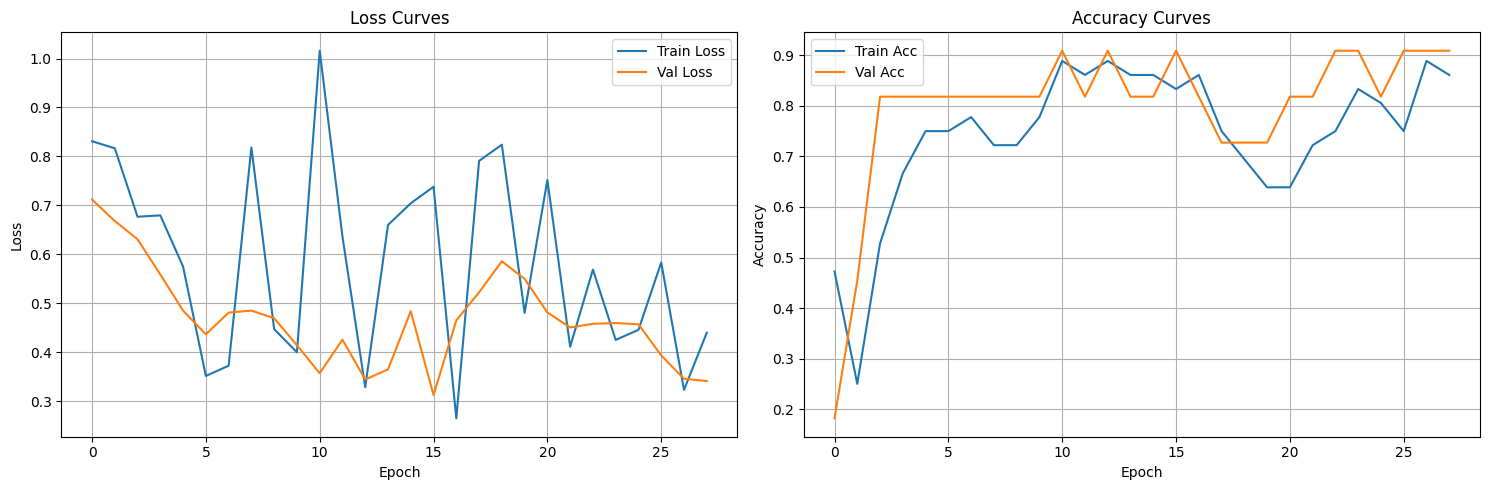

In [94]:
!start mlflow ui --backend-store-uri "file:///C:/Users/lucaz/Desktop/TESI/colab_mlruns_3c"

# RESULT EXPLAINABILITY

In [101]:
## helper visualization functions

In [ ]:
test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_labels)]
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

In [ ]:
from utils.data_visualization_functions import visualize_batch_histograms

visualize_batch_histograms(images, labels,class1_name, class0_name, bins=256)

In [ ]:
def visualize_batch_boxplots(images, labels):
    """
    Visualizes box plots of pixel intensity distributions for a batch of images,
    including labels in the plot titles.

    Args:
        images: A PyTorch tensor of images (B, C, H, W).
        labels: A PyTorch tensor of labels (B,).
    """

    images_np = images.cpu().numpy()
    num_images = images_np.shape[0]
    num_channels = images_np.shape[1]

    fig, axes = plt.subplots(num_images, num_channels, figsize=(5 * num_channels, 5 * num_images))

    for i in range(num_images):
        label = extract_labels_meaning([labels[i].item()])
        for j in range(num_channels):
            ax = axes[i, j] if num_images > 1 else axes[j]
            ax.boxplot(images_np[i, j].flatten(), vert=True, patch_artist=True, showfliers=False)
            ax.set_title(f"Image {i+1} (Label: {label[0]}), Channel {j+1}")  # Add label to title
            ax.set_ylabel("Pixel Value")
    plt.tight_layout()
    plt.show()

# Example Usage (assuming you have your test_loader and device set up):
example_batch = next(iter(test_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = example_batch["image"].to(device)  # (B, C, H, W)
labels = example_batch["label"].to(device)  # (B,)

visualize_batch_boxplots(images, labels)

In [ ]:
def print_batch_image_statistics(images, labels):
    """
    Calculates and prints statistics (min, max, mean, std) for each image
    in a batch, along with the corresponding label.

    Args:
        images: A PyTorch tensor of images (B, C, H, W).
        labels: A PyTorch tensor of labels (B,).
    """

    num_images = images.shape[0]
    num_channels = images.shape[1]

    for i in range(num_images):
        label = extract_labels_meaning([labels[i].item()],class1_name, class0_name)
        print(f"Image {i+1} (Label: {label[0]}):")  # Print label
        for j in range(num_channels):
            channel_data = images[i, j].flatten()

            min_val = torch.min(channel_data).item()
            max_val = torch.max(channel_data).item()
            mean_val = torch.mean(channel_data).item()
            std_val = torch.std(channel_data).item()

            print(f"  Channel {j+1}:")
            print(f"    Min: {min_val:.4f}")
            print(f"    Max: {max_val:.4f}")
            print(f"    Mean: {mean_val:.4f}")
            print(f"    Std: {std_val:.4f}")
        print("-" * 20)

# Example Usage (using your code structure)
example_batch = next(iter(test_loader))
images = example_batch["image"].to(device)
labels = example_batch["label"].to(device)  # Get labels

print_batch_image_statistics(images, labels)

In [130]:
#DO NOT DELETE
def get_mlrun_base_folder():
  if kaggle:
      print("you are in kaggle so there's a problem")
      return "/kaggle/input/rgb-tif/"
  elif gdrive:
      print("you are in google drive")
      return "/content/drive/MyDrive/TESI/colab_mlruns"
  else:
      print("you are in local")
      return r"C:\Users\lucaz\Desktop\TESI\mlruns_3c"

# 3. Function to Get Experiment ID from Name
def get_experiment_id_byName(experiment_name):
    """Retrieves the experiment ID from the experiment name."""
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        raise ValueError(f"Experiment '{experiment_name}' not found.")
    return experiment.experiment_id

def get_run_name_by_id(run_id, tracking_uri, experiment_id=None):
    """
    Prints the name of an MLflow run given its ID.

    Args:
        run_id: The ID of the MLflow run.
        tracking_uri: The MLflow tracking URI.
        experiment_id: The ID of the experiment (optional). If not provided,
                       it will attempt to find the experiment based on the run ID.
    """
    mlflow.set_tracking_uri(tracking_uri)
    try:
        run = mlflow.get_run(run_id)
        if run:
          return run.data.tags.get('mlflow.runName', 'N/A')  # Get the run name, or 'N/A' if it doesn't exist
        else:
            print(f"Run with ID '{run_id}' not found.")

    except Exception as e:
        print(f"An error occurred: {e}")

you are on local
Tracking URI: file:///C:/Users/lucaz/Desktop/TESI/mlruns_3c
Experiment 'PD_vs_MSA-P_classifier' has ID: 242062506146077621
Runs for experiment 'PD_vs_MSA-P_classifier':
  Run ID: 7cb9350e569e42caafb3833781dfff4b, Run Name: vit_S_NN_NT_4folds_learnable_1.2M_param
  Run ID: 46aef00c28ea41bca9cce8de1000d4f4, Run Name: vit_S_NN_NT_4folds_syncos_1.2M_param


In [ ]:
#SHOW RUNS ID AND NAME FOR A SPECIFIC EXPERIMENT
def print_run_ids_and_names(experiment_name, tracking_uri):
    """
    Prints the Run IDs and their associated run names (mlflow.runName tag)
    for a given experiment name.

    Args:
        experiment_name (str): The name of the MLflow experiment.
        tracking_uri (str): The MLflow tracking URI.
    """

    mlflow.set_tracking_uri(tracking_uri)

    try:
        # Get the experiment by name
        experiment = mlflow.get_experiment_by_name(experiment_name)

        if experiment is None:
            print(f"Experiment '{experiment_name}' not found.")
            return

        # Search for all runs within the experiment
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

        if runs.empty:
            print(f"No runs found for experiment '{experiment_name}'.")
            return

        print(f"Runs for experiment '{experiment_name}':")
        for index, run in runs.iterrows():
            run_id = run["run_id"]
            run_name = run["tags.mlflow.runName"]  # Access the run name tag
            print(f"  Run ID: {run_id}, Run Name: {run_name}")

    except Exception as e:
        print(f"An error occurred: {e}")


# print all the models id and name under the experiment

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)  # Replace with your tracking URI
print(f"Tracking URI: {tracking_uri}")
mlflow.set_tracking_uri(tracking_uri)
experiment_name = f"{class0_name}_vs_{class1_name}_classifier"  # Replace with your experiment namef"{class0_name}_vs_{class1_name}_classifier"
experiment_id = get_experiment_id_byName(experiment_name)
print(f"Experiment '{experiment_name}' has ID: {experiment_id}")
print_run_ids_and_names(experiment_name, tracking_uri)

you are in local
base folder C:\Users\lucaz\Desktop\TESI\mlruns_3c
test path C:\Users\lucaz\Desktop\TESI\mlruns_3c\242062506146077621\46aef00c28ea41bca9cce8de1000d4f4\artifacts\model
normalized path C:\Users\lucaz\Desktop\TESI\mlruns_3c\242062506146077621\46aef00c28ea41bca9cce8de1000d4f4\artifacts\model
Model vit_S_NN_NT_4folds_syncos_1.2M_param Loaded successfully


In [48]:
# This cell loads a pre-trained model from a specified run ID,
# and prepares the model for inference by moving it to the appropriate device (CPU or GPU).

# 2. Run ID and Artifact Path (same as before)
run_id = input("Enter the run ID you see in the above outputs: ")

model_path = "model"  # Or whatever artifact path you used
base_folder = get_mlrun_base_folder()
print("base folder",base_folder)
# 3. Local path to the downloaded artifact directory
local_artifact_path = os.path.join(base_folder, experiment_id, run_id) # use the exact folder path on you computer
test = os.path.join(local_artifact_path, "artifacts", model_path)
print("test path",test)
normalize_path = os.path.normpath(test)
print("normalized path",normalize_path)
# 4. Load the model using the local path
if os.path.exists(normalize_path): # this mean it was created under an artifact directory
    model = mlflow.pytorch.load_model(os.path.join(local_artifact_path, "artifacts", model_path), map_location=torch.device('cpu'))
else: # we have to deal with the empty path case
    print("using empty path")
    model = mlflow.pytorch.load_model(local_artifact_path, artifact_path= model_path, map_location=torch.device('cpu')) # pass a valid artifact path

# 5. (Optional) Prepare for inference

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()
run_name = get_run_name_by_id(run_id,tracking_uri,experiment_id)
# 6. (Optional) Test loading
print(f"Model {run_name} Loaded successfully")

TypeError: max() received an invalid combination of arguments - got (tuple, dim=int), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)



Test Set Metrics:
Test Accuracy: 0.9000
Test F1 Score: 0.9231
Test Balanced Accuracy: 0.9286

Confusion Matrix:
 [[3 0]
 [1 6]]


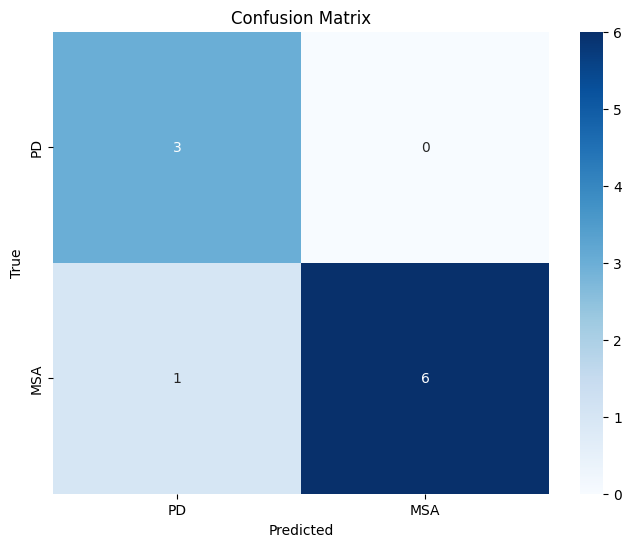

In [32]:
# -------------------------------------------------------------------------
# STEP 6 : Evaluate on test set
# -------------------------------------------------------------------------

# 6.1 - Create the test Dataset and DataLoader
test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_labels)]
test_transforms = val_transforms
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

# 6.3 - Inference on the test set
y_true, y_pred = [], []
misclassified_images = []  # Store misclassified image data and info
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images_batch, labels_batch = batch["image"].to(device), batch["label"].to(device).long()
        outputs, _ = model(images_batch)
        _, predicted = torch.max(outputs, dim=1)
        y_true.extend(labels_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # Find misclassifications in the current batch
        batch_true = labels_batch.cpu().numpy()
        batch_pred = predicted.cpu().numpy()
        batch_images = images_batch.cpu().numpy()

        misclassified_indices = np.where(batch_true != batch_pred)[0]

        for i in misclassified_indices:
            misclassified_images.append({
                "image": batch_images[i],
                "true_label": batch_true[i],
                "pred_label": batch_pred[i],
                "batch_index": batch_idx  # For context if needed
            })

# 6.4 - Compute test metrics including balanced accuracy
test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='binary')
test_balanced_acc = balanced_accuracy_score(y_true, y_pred)

# 6.5 - Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[class0_name, class1_name],  # or your class names
    yticklabels=[class0_name, class1_name]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## ATTENTION ROLL-OUT

In [ ]:

# -------------------------------------------------------------------------
# Helper: Attention Rollout Function
# -------------------------------------------------------------------------
from utils.vit_explanation_functions import compute_attention_rollout_matrix


def compute_rollout(attentions):
    """
    Computes the aggregated (rolled out) attention across layers.
    
    Args:
        attentions (list of torch.Tensor): Each tensor is [B, num_heads, tokens, tokens].
        
    Returns:
        torch.Tensor: Rolled out attention with shape [B, tokens, tokens].
    """
    rollout = None
    for attn in attentions:
        # Average attention over heads -> [B, tokens, tokens]
        attn_heads_fused = attn.mean(dim=1)
        B, N, _ = attn_heads_fused.shape
        # Add the identity matrix to account for residual connections.
        identity = torch.eye(N, device=attn_heads_fused.device).unsqueeze(0).expand(B, -1, -1)
        attn_heads_fused = attn_heads_fused + identity
        # Renormalize each row
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        # Multiply the attentions: each layer’s attention is combined multiplicatively.
        if rollout is None:
            rollout = attn_heads_fused
        else:
            rollout = torch.matmul(attn_heads_fused, rollout)
    return rollout

# -------------------------------------------------------------------------
# STEP 6: Evaluate on Test Set and Generate Interpretability Overlays
# -------------------------------------------------------------------------
# 6.1 - Create the test Dataset and DataLoader
test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_labels)]
test_transforms = val_transforms  # your validation/test transforms
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)
output_path = "./attention_overlays"  # Folder to save overlays

def save_attention_overlays_from_loader(test_loader, model, output_path, device):
    """
    Generates and saves attention rollout overlay images from a given DataLoader.

    Args:
        loader (DataLoader): A pre-built DataLoader yielding batches with keys "image" and "label".
        model (torch.nn.Module): The trained ViT model.
        output_path (str): Folder where overlay images will be saved.
        device (torch.device): Device on which the model runs.
        cfg: Configuration object/dictionary with data_loading settings.
    """
    import os
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    from utils.data_visualization_functions import min_max_normalization, imageNet_denormalize

    os.makedirs(output_path, exist_ok=True)
    # Gather attention matrices from each block.
# Each attention matrix should have shape: [B, num_heads, tokens, tokens]
    attentions = []
    for blk in model.blocks:
        # blk.attn is the SABlock instance; if save_attn is True, it stores the attention in att_mat.
        attn = blk.attn.att_mat  # This is a tensor with shape [B, num_heads, tokens, tokens]
        attentions.append(attn)
        
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images_batch = batch["image"].to(device)          # [B, 3, 224, 224]
            labels_batch = batch["label"].to(device).long()     # [B]

            # Run inference; model returns (outputs, hidden_states)
            outputs, _ = model(images_batch)
            _, predicted = torch.max(outputs, dim=1)

            # Collect attention matrices from each TransformerBlock.
            attentions = [blk.attn.att_mat for blk in model.blocks]  # each: [B, num_heads, tokens, tokens]
            rollout = compute_attention_rollout_matrix(attentions)  # shape: [B, tokens, tokens]

            # Convert images and labels to numpy arrays for visualization.
            batch_images_np = images_batch.cpu().numpy()  # shape: [B, C, H, W]
            batch_labels_np = labels_batch.cpu().numpy()
            batch_pred_np = predicted.cpu().numpy()

            # Process each image in the batch individually.
            for i in range(images_batch.size(0)):
                rollout_sample = rollout[i]  # [tokens, tokens]
                # Skip the CLS token: extract attention to patch tokens.
                class_attn = rollout_sample[0, 1:]
                grid_size = int(np.sqrt(class_attn.shape[0]))  # e.g., 7 for a 7x7 grid
                attn_map = class_attn.reshape(grid_size, grid_size)

                # Upsample the attention map to the original image size.
                attn_map_tensor = attn_map.clone().detach().unsqueeze(0).unsqueeze(0)
                attn_map_tensor = F.interpolate(attn_map_tensor, size=(224, 224), mode='bilinear', align_corners=False)
                attn_map_upsampled = attn_map_tensor.squeeze().cpu().numpy()

                # Convert the original image from [C, H, W] to [H, W, C] format.
                orig_img = batch_images_np[i].transpose(1, 2, 0)
                orig_img = imageNet_denormalize(orig_img)
                orig_img = min_max_normalization(orig_img)

                # Normalize the attention map for visualization.
                attn_map_norm = min_max_normalization(attn_map_upsampled)

                # Create an overlay plot.
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(orig_img)
                ax[0].set_title("Original Image")
                ax[0].axis("off")

                ax[1].imshow(orig_img)
                ax[1].imshow(attn_map_norm, cmap="jet", alpha=0.5)
                ax[1].set_title(f"Overlay\nTrue: {batch_labels_np[i]}, Pred: {batch_pred_np[i]}")
                ax[1].axis("off")
                plt.suptitle(f"Batch {batch_idx} - Sample {i}")

                # Save the overlay figure.
                output_filename = os.path.join(output_path, f"overlay_batch{batch_idx}_sample{i}.png")
                fig.savefig(output_filename)
                plt.close(fig)
                
# Call the function to save overlays
#save_attention_overlays_from_loader(test_loader, model, output_path, device)

## GRAD CAM

In [28]:
print_layers(model)


patch_embedding
patch_embedding.patch_embeddings
patch_embedding.dropout
blocks
blocks.0
blocks.0.mlp
blocks.0.mlp.linear1
blocks.0.mlp.linear2
blocks.0.mlp.fn
blocks.0.mlp.drop1
blocks.0.mlp.drop2
blocks.0.norm1
blocks.0.attn
blocks.0.attn.out_proj
blocks.0.attn.qkv
blocks.0.attn.to_q
blocks.0.attn.input_rearrange
blocks.0.attn.out_rearrange
blocks.0.attn.drop_output
blocks.0.attn.drop_weights
blocks.0.norm2
blocks.0.norm_cross_attn
blocks.0.cross_attn
blocks.0.cross_attn.out_proj
blocks.0.cross_attn.to_q
blocks.0.cross_attn.to_k
blocks.0.cross_attn.to_v
blocks.0.cross_attn.input_rearrange
blocks.0.cross_attn.out_rearrange
blocks.0.cross_attn.drop_output
blocks.0.cross_attn.drop_weights
blocks.1
blocks.1.mlp
blocks.1.mlp.linear1
blocks.1.mlp.linear2
blocks.1.mlp.fn
blocks.1.mlp.drop1
blocks.1.mlp.drop2
blocks.1.norm1
blocks.1.attn
blocks.1.attn.out_proj
blocks.1.attn.qkv
blocks.1.attn.to_q
blocks.1.attn.input_rearrange
blocks.1.attn.out_rearrange
blocks.1.attn.drop_output
blocks.1.at

In [36]:
from monai.visualize import GradCAM

class ViTGradCAM(GradCAM):
    def __init__(self, nn_module, target_layers, patch_size=16, img_size=224):
        super().__init__(nn_module=nn_module, target_layers=target_layers)
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2

    def _compute_heatmap(self, input_tensor):
        # Forward pass
        activations = self.activations_hook  # Shape: [B, seq_len, dim]

        # Gradients w.r.t. activations
        grads = self.gradients_hook  # Shape: [B, seq_len, dim]

        # Exclude class token (first element in sequence)
        patch_activations = activations[:, 1:, :]  # Shape: [B, num_patches, dim]
        patch_grads = grads[:, 1:, :]  # Shape: [B, num_patches, dim]

        # Compute weights (mean over sequence and dimension)
        weights = torch.mean(patch_grads, dim=[1, 2], keepdim=True)  # Shape: [B, 1, 1]

        # Weighted sum of activations
        cam = torch.sum(patch_activations * weights, dim=-1)  # Shape: [B, num_patches]

        # Reshape to 2D grid
        grid_size = int(self.num_patches ** 0.5)
        cam = cam.reshape(-1, grid_size, grid_size)  # Shape: [B, grid_size, grid_size]

        # Interpolate to original image size
        cam = torch.nn.functional.interpolate(
            cam.unsqueeze(1),
            size=(self.img_size, self.img_size),
            mode="bicubic",
            align_corners=False
        )  # Shape: [B, 1, H, W]

        return cam.squeeze(1)  # Shape: [B, H, W]

# Example for MONAI ViT:
target_layer = "blocks.5.cross_attn"
# Initialize GradCAM
gradcam = ViTGradCAM(
    nn_module=model,
    target_layers=[target_layer],
    patch_size=32,  # Match your ViT's patch size
    img_size=224
)

# Forward pass
model.eval()
single_image = images[0].unsqueeze(0)  # Shape: [1, C, H, W]
cam_tensor = gradcam(x=single_image)  # Shape: [1, H, W]

# Convert to numpy
cam_np = cam_tensor.squeeze().cpu().numpy()


def get_overlay_heatmap(image, heatmap, alpha=0.5):
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Plot
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.imshow(heatmap, cmap="jet", alpha=alpha)
    plt.axis("off")
    plt.show()

# Example
get_overlay_heatmap(single_image[0], cam_np)

Not all target_layers exist in the network module: targets: ('blocks.5.cross_attn',).


NameError: name 'images' is not defined

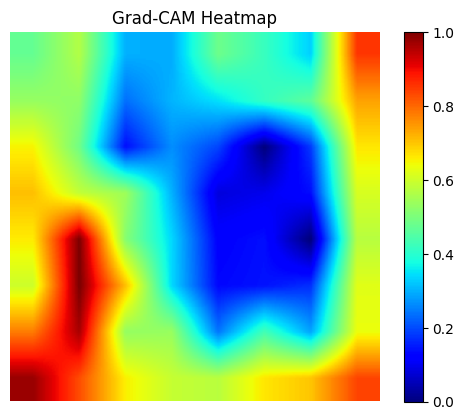

In [ ]:
## example with one image and one label
target_layer = input("insert the target layer name for gradcam, usually the last conv layer: ")

gradcam = GradCAM(
    nn_module=model,             # your trained model
    target_layers=[target_layer],  # the layer you've chosen
    # optional: set relu=True to ensure ReLU is applied before computing GradCAM
)

model.eval()

# Suppose you just take the first batch from your val_loader or test_loader:
example_batch = next(iter(test_loader))
images = example_batch["image"].to(device)  # shape: (B, C, H, W) for 2D images
labels = example_batch["label"].to(device)  # shape: (B,)
#visualize_batch_histograms(images,labels)
#visualize_batch_boxplots(images,labels)
#print_batch_image_statistics(images,labels)

# Let's pick the first image from the batch
single_image = images[0].unsqueeze(0)  # shape: unsqueeze add the first 1 to the dimension which now is (1, C, H, W)
print(f"single image shape:", single_image.shape) #torch.Size([1, 3, 256, 256])
single_label = labels[0].unsqueeze(0)
# shape: (1, 1, H, W) for 2D images
#the before unsqueeze are done since gradcam works with 4D tensors
cam_tensor = gradcam(x=single_image) # shape: (B, C, H, W) for 2D images = ([8, 1, 512, 512])
print("gradcam shape", cam_tensor.shape) #torch.Size([1, 1, 256, 256])
cam_np = cam_tensor.squeeze().cpu().numpy()  #squeeze removes dimensions of size=1 new shape: (H, W)

In [ ]:
plt.imshow(cam_np, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()

images batch shape : torch.Size([6, 3, 256, 256])
cam_batch shape:  torch.Size([6, 1, 256, 256])
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_0.png
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_1.png
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_2.png
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_3.png
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_4.png
cam (1, 256, 256)
Saved Grad-CAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\batch_0_img_5.png


In [37]:
# 1) Define your Grad-CAM once
model.eval()
target_layer = target_layer  # or whatever layer name you use
gradcam = GradCAM(nn_module=model, target_layers=[target_layer])

# 2) Loop over your test DataLoader
output_dir = os.path.join(base_dir,"gradcam_outputs",run_name if run_name else experiment_name)  # folder to save CAM overlays or images
os.makedirs(output_dir, exist_ok=True)

for batch_idx, batch_data in enumerate(test_loader):
    images = batch_data["image"].to(device)  # shape: (B, C, H, W) for 2D images
    labels = batch_data["label"].to(device)
    print(f"images batch shape : {images.shape}")
    # 3) Compute Grad-CAM for the entire batch
    # (optionally specify class_idx if doing multi-class or binary with out_channels=1)
    cam_batch = gradcam(x=images)  # shape: (B, 1, H, W)
    print(f"cam_batch shape:  {cam_batch.shape}")
    # 4) For each image in the batch, visualize or save
    for i in range(images.shape[0]):
        single_image = images[i].cpu().numpy()  # shape (C, H, W)
        single_cam = cam_batch[i].cpu().numpy() # shape (1, H, W)
        print(f"cam {single_cam.shape}")
        image_label = extract_labels_meaning([labels[i].item()])
        # Remove extra dimensions
        single_image = np.transpose(single_image, (1, 2, 0))  # => (H, W, C)
        single_cam = single_cam.squeeze(axis=0)               # => (H, W)
        #single_image_norm = single_image.astype(np.float32) / 255.0  # if 8-bit TODO do i really need this?

        # Normalize image if needed (especially if it's very bright or large range)
        # Here we do per-channel normalization
        single_image_norm = min_max_rescale_for_display(single_image)
        # for c in range(single_image.shape[-1]):
        #     ch_min, ch_max = single_image[..., c].min(), single_image[..., c].max()
        #     if (ch_max - ch_min) > 1e-8:
        #         single_image[..., c] = (single_image[..., c] - ch_min) / (ch_max - ch_min)

        # Normalize Grad-CAM
        cam_normalized =single_cam.squeeze()
        cam_normalized = min_max_rescale_for_display(single_cam)

        # Plot or save
        fig, axarr = plt.subplots(1, 2, figsize=(10, 4))

        # Left: original
        axarr[0].imshow(single_image_norm, cmap='gray' if single_image.shape[-1] == 1 else None)
        axarr[0].set_title(f"Original Image (Label: {image_label})")
        axarr[0].axis('off')

        # Right: overlay
        axarr[1].imshow(single_image_norm, cmap='gray' if single_image.shape[-1] == 1 else None)
        axarr[1].imshow(cam_normalized, cmap='jet', alpha=0.5)
        axarr[1].set_title("Grad-CAM Overlay")
        axarr[1].axis('off')

        plt.tight_layout()

        # Save as PNG (optional)
        save_path = os.path.join(output_dir, f"batch_{batch_idx}_img_{i}.png")
        plt.savefig(save_path, dpi=100, bbox_inches='tight')
        plt.close(fig)

        print(f"Saved Grad-CAM overlay: {save_path}")


images batch shape : torch.Size([10, 3, 224, 224])


AttributeError: 'tuple' object has no attribute 'max'

images batch shape : torch.Size([6, 3, 256, 256])
Grad-CAM++ output shape: torch.Size([1, 1, 256, 256])
Grad-CAM++ output shape after squeeze: (256, 256)


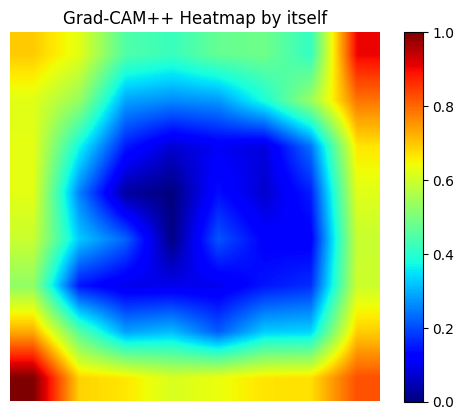

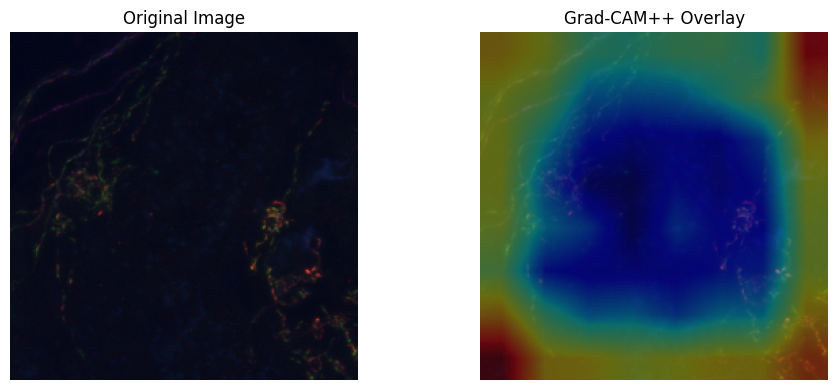

In [ ]:
## GRAD CAM ++

In [ ]:
from monai.visualize import GradCAMpp

def visualize_gradcam_for_single_image(model, test_loader, target_layer, min_max_rescale_for_display):
    """
    Gets a single image from the test_loader, generates and visualizes Grad-CAM++ for it.

    Args:
        model: The PyTorch model.
        test_loader: The DataLoader for the test dataset.
        target_layer: The target layer for Grad-CAM (string).
        min_max_rescale_for_display: Function to rescale image/array to [0, 1].
    """
    # Get the device from the model
    device = next(model.parameters()).device

    gradcampp = GradCAMpp(
        nn_module=model,                           # your trained model
        target_layers=[target_layer],              # list with the layer name (or submodule reference)
        register_backward=True                     # recommended so that backward hooks get registered
    )
    model.eval()

    # Get a batch from your test_loader
    example_batch = next(iter(test_loader))
    images = example_batch["image"].to(device)  # (B, C, H, W) if 2D
    labels = example_batch["label"].to(device)  # (B,)
    print(f"images batch shape : {images.shape}")
    # Select the first image from the batch
    single_image = images[0].unsqueeze(0)       # => (1, C, H, W)
    single_label = labels[0].unsqueeze(0)       # => (1,)

    # Because your model has out_channels=2, let's pick class_idx=1:
    cam_result = gradcampp(x=single_image)  # => shape (1, 1, H, W)
    print("Grad-CAM++ output shape:", cam_result.shape)
    # cam_result is shape (1, 1, H, W). Squeeze to (H, W).
    cam_tensor = cam_result.squeeze(0).squeeze(0).cpu().numpy()  # => shape (H, W)
    print("Grad-CAM++ output shape after squeeze:", cam_tensor.shape)
    plt.imshow(cam_tensor, cmap="jet")
    plt.colorbar()
    plt.title("Grad-CAM++ Heatmap by itself")
    plt.axis("off")
    plt.show()
    # Convert your single_image to a NumPy array
    # single_image was (1, C, H, W). Now shape => (C, H, W) after squeeze
    input_image_np = single_image.squeeze(0).cpu().numpy()  # => (C, H, W)

    # Transpose to (H, W, C) for matplotlib, if you have 3 channels
    input_image_np = np.transpose(input_image_np, (1, 2, 0))  # => (H, W, C)

    # If images are 8-bit [0..255], convert to float [0..1]
    input_image_np = min_max_rescale_for_display(input_image_np)

    # Now overlay
    plt.figure(figsize=(10, 4))

    # Left: original
    plt.subplot(1, 2, 1)
    plt.imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
    plt.title("Original Image")
    plt.axis("off")
    # Right: overlay
    plt.subplot(1, 2, 2)
    plt.imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
    plt.imshow(cam_tensor, cmap="jet", alpha=0.4)
    plt.title("Grad-CAM++ Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize Grad-CAM++ for the single image
visualize_gradcam_for_single_image(model, test_loader, target_layer, min_max_rescale_for_display)

Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_0.png
Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_1.png
Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_2.png
Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_3.png
Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_4.png
Saved Grad-CAM++ overlay: C:\Users\lucaz\Desktop\TESI\gradcam++_outputs\DenseNet121_S_Nspec\batch_0_img_5.png


In [ ]:

def process_and_save_gradcampp_batch(model, test_loader, target_layer, base_dir, min_max_rescale_for_display, extract_labels_meaning):
    """
    Processes a DataLoader, generates Grad-CAM++ for each image, and saves visualizations.

    Args:
        model: The PyTorch model.
        test_loader: The DataLoader for the dataset.
        target_layer: The target layer for Grad-CAM (string).
        base_dir: The base directory to save output.
        min_max_rescale_for_display: A function for min-max rescaling an image or numpy array.
        extract_labels_meaning: A function for extracting the meaning of labels (optional).
    """

    device = next(model.parameters()).device
    model.eval()
    gradcampp = GradCAMpp(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    output_dir = os.path.join(base_dir, "gradcam++_outputs", run_name if run_name else experiment_name)
    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, batch_data in enumerate(test_loader):
        images = batch_data["image"].to(device)  # (B, C, H, W)
        labels = batch_data["label"].to(device)  # (B,)

        for i in range(images.shape[0]):
            # Select the i-th image and label from the batch
            single_image = images[i].unsqueeze(0)  # (1, C, H, W)
            single_label = labels[i].unsqueeze(0)  # (1,)

            # Get label meaning (if extract_labels_meaning is provided)
            if extract_labels_meaning:
                image_label = extract_labels_meaning([single_label.item()])
            else:
                image_label = f"Class {single_label.item()}"

            # Compute Grad-CAM++
            cam_result = gradcampp(x=single_image, class_idx=1)  # Adjust class_idx if needed

            # Squeeze to (H, W)
            cam_tensor = cam_result.squeeze(0).squeeze(0).cpu().numpy()

            # Convert image to NumPy and transpose to (H, W, C)
            input_image_np = single_image.squeeze(0).cpu().numpy()
            input_image_np = np.transpose(input_image_np, (1, 2, 0))

            # Rescale image and CAM
            input_image_np = min_max_rescale_for_display(input_image_np)
            cam_normalized = min_max_rescale_for_display(cam_tensor)

            # Create overlay visualization
            fig, axarr = plt.subplots(1, 2, figsize=(10, 4))

            # Left: original
            axarr[0].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[0].set_title(f"Original Image (Label: {image_label})")
            axarr[0].axis('off')

            # Right: overlay
            axarr[1].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[1].imshow(cam_normalized, cmap="jet", alpha=0.5)
            axarr[1].set_title("Grad-CAM++ Overlay")
            axarr[1].axis('off')

            plt.tight_layout()

            # Save as PNG
            save_path = os.path.join(output_dir, f"batch_{batch_idx}_img_{i}.png")
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close(fig)

            print(f"Saved Grad-CAM++ overlay: {save_path}")

process_and_save_gradcampp_batch(model, test_loader, target_layer, base_dir, min_max_rescale_for_display, extract_labels_meaning)

Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_0.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_1.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_2.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_3.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_4.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_5.png


In [ ]:
def process_and_save_gradcam_comparison(model, test_loader, target_layer, base_dir, min_max_rescale_for_display, extract_labels_meaning):
    """
    Processes a DataLoader, generates Grad-CAM and Grad-CAM++ overlays for each image, and saves visualizations.

    Args:
        model: The PyTorch model.
        test_loader: The DataLoader for the dataset.
        target_layer: The target layer for Grad-CAM (string).
        base_dir: The base directory to save output.
        min_max_rescale_for_display: A function for min-max rescaling an image or numpy array.
        extract_labels_meaning: A function for extracting the meaning of labels (optional).
    """

    device = next(model.parameters()).device
    model.eval()

    gradcampp = GradCAMpp(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    gradcam = GradCAM(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    output_dir = os.path.join(base_dir, "comparison_gradcam_outputs", run_name if run_name else experiment_name)
    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, batch_data in enumerate(test_loader):
        images = batch_data["image"].to(device)  # (B, C, H, W)
        labels = batch_data["label"].to(device)  # (B,)

        for i in range(images.shape[0]):
            # Select the i-th image and label from the batch
            single_image = images[i].unsqueeze(0)  # (1, C, H, W)
            single_label = labels[i].unsqueeze(0)  # (1,)

            # Get label meaning (if extract_labels_meaning is provided)
            if extract_labels_meaning:
                image_label = extract_labels_meaning([single_label.item()])
            else:
                image_label = f"Class {single_label.item()}"

            # Compute Grad-CAM and Grad-CAM++ for single image
            cam_result = gradcam(x=single_image, class_idx=1)  # Adjust class_idx if needed
            campp_result = gradcampp(x=single_image, class_idx=1)  # Adjust class_idx if needed

            # Squeeze to (H, W)
            cam_tensor = cam_result.squeeze(0).squeeze(0).cpu().numpy()
            campp_tensor = campp_result.squeeze(0).squeeze(0).cpu().numpy()

            # Convert image to NumPy and transpose to (H, W, C)
            input_image_np = single_image.squeeze(0).cpu().numpy()
            input_image_np = np.transpose(input_image_np, (1, 2, 0))

            # Rescale image and CAMs
            input_image_np = min_max_rescale_for_display(input_image_np)
            cam_normalized = min_max_rescale_for_display(cam_tensor)
            campp_normalized = min_max_rescale_for_display(campp_tensor)

            # Create overlay visualization
            fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

            # Left: original
            axarr[0].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[0].set_title(f"Original Image (Label: {image_label})")
            axarr[0].axis('off')

            # Middle: Grad-CAM overlay
            axarr[1].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[1].imshow(cam_normalized, cmap="jet", alpha=0.5)
            axarr[1].set_title("Grad-CAM Overlay")
            axarr[1].axis('off')

            # Right: Grad-CAM++ overlay
            axarr[2].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[2].imshow(campp_normalized, cmap="jet", alpha=0.5)
            axarr[2].set_title("Grad-CAM++ Overlay")
            axarr[2].axis('off')

            plt.tight_layout()

            # Save as PNG
            save_path = os.path.join(output_dir, f"batch_{batch_idx}_img_{i}.png")
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close(fig)

            print(f"Saved Grad-CAM and Grad-CAM++ overlays: {save_path}")

process_and_save_gradcam_comparison(model, test_loader, target_layer, base_dir, min_max_rescale_for_display, extract_labels_meaning)

In [ ]:
# RESULTS VISUALIZATIONS

you are on local

Available experiments:
1. Default
2. MSA_vs_control_classifier
3. ctrl_vs_MSA_classifier
4. ctrl_vs_MSA_classifier_3c

Checking LOCAL tracking URI...
Experiment 'ctrl_vs_MSA_classifier_3c' not found in local

Checking COLAB tracking URI...
Found 2 runs in colab experiment (ID: 833241302715829213)
 | Name: DenseNet121_TL_SNspec_10%test
 | Name: DenseNet121_TL_SNspec
🚨 Error processing colab tracking URI: "['metrics.mean_val_balanced_accuracy'] not in index"

Checking KAGGLE tracking URI...
Experiment 'ctrl_vs_MSA_classifier_3c' not found in kaggle

❌ No runs found across all tracking URIs


In [ ]:
import pandas as pd
import mlflow
from mlflow.tracking import MlflowClient

# List of tracking URIs to check
tracking_uris = [
    {"name": "local", "uri": get_tracking_uri(gdrive,kaggle,linux)},
    {"name": "colab", "uri": "file:///C:/Users/lucaz/Desktop/TESI/colab_mlruns_3c"},
    {"name": "kaggle", "uri": "file:///C:/Users/lucaz/Desktop/TESI/kaggle_mlruns"}
]

# First pass: Collect all experiment names from all tracking URIs
all_experiments = set() #set of unique experiments
for uri_info in tracking_uris:
    try:
        mlflow.set_tracking_uri(uri_info["uri"])
        for exp in mlflow.search_experiments():
            all_experiments.add(exp.name)
    except Exception as e:
        print(f"⚠️ Couldn't connect to {uri_info['name']} tracking URI: {e}")

# Let user select an experiment
print("\nAvailable experiments:")
for i, name in enumerate(sorted(all_experiments)):
    print(f"{i+1}. {name}")

selected_idx = int(input("\nEnter experiment number: ")) - 1
selected_experiment = sorted(all_experiments)[selected_idx] #get the experiment name

# Second pass: Get runs from each source for selected experiment
combined_runs_df = pd.DataFrame()
metrics_of_interest = [
    'tags.mlflow.runName',
    'metrics.test_accuracy',
    'metrics.test_recall',
    'metrics.test_precision',
    'metrics.test_f1',
    'metrics.val_accuracy',
    'metrics.mean_val_accuracy',
    'metrics.mean_val_loss',
    'metrics.mean_val_f1',
    #'metrics.mean_val_balanced_accuracy'
]

for uri_info in tracking_uris:
    try:
        mlflow.set_tracking_uri(uri_info["uri"])
        print(f"\nChecking {uri_info['name'].upper()} tracking URI...")

        experiment = mlflow.get_experiment_by_name(selected_experiment)
        if not experiment:
            print(f"Experiment '{selected_experiment}' not found in {uri_info['name']}")
            continue

        runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        if runs_df.empty:
            print(f"No runs found in {uri_info['name']}")
            continue

        # Print detailed run info for this source
        print(f"Found {len(runs_df)} runs in {uri_info['name']} experiment (ID: {experiment.experiment_id})")
        for _, row in runs_df.iterrows():
            run_name = row.get('tags.mlflow.runName', 'NO_NAME')
            print(f" | Name: {run_name}")

        # Add to combined dataframe
        runs_df = runs_df[metrics_of_interest]
        combined_runs_df = pd.concat([combined_runs_df, runs_df], ignore_index=True)

    except Exception as e:
        print(f"🚨 Error processing {uri_info['name']} tracking URI: {e}")

# Process combined results
if not combined_runs_df.empty:
    print("\nCombining results from all sources...")
    combined_runs_df.dropna(subset=metrics_of_interest, inplace=True)
    combined_runs_df.drop_duplicates(subset=['tags.mlflow.runName'], keep='first', inplace=True)
    combined_runs_df.sort_values(by="metrics.mean_val_accuracy", ascending=False, inplace=True)

    print(f"\nFinal combined dataset ({len(combined_runs_df)} runs):")
    display(combined_runs_df)
else:
    print("\n❌ No runs found across all tracking URIs")

,tags.mlflow.runName,metrics.test_accuracy,metrics.test_recall,metrics.test_precision,metrics.test_f1,metrics.val_accuracy,metrics.mean_val_accuracy,metrics.mean_val_loss,metrics.mean_val_f1,run_id,experiment_id,status,artifact_uri,start_time,end_time
0,TL_toDeleteOnlydebug,0.5,0.75,0.6,0.666667,0.576923,0.67735,0.645731,0.776351,NaN,NaN,NaN,NaN,NaN,NaN


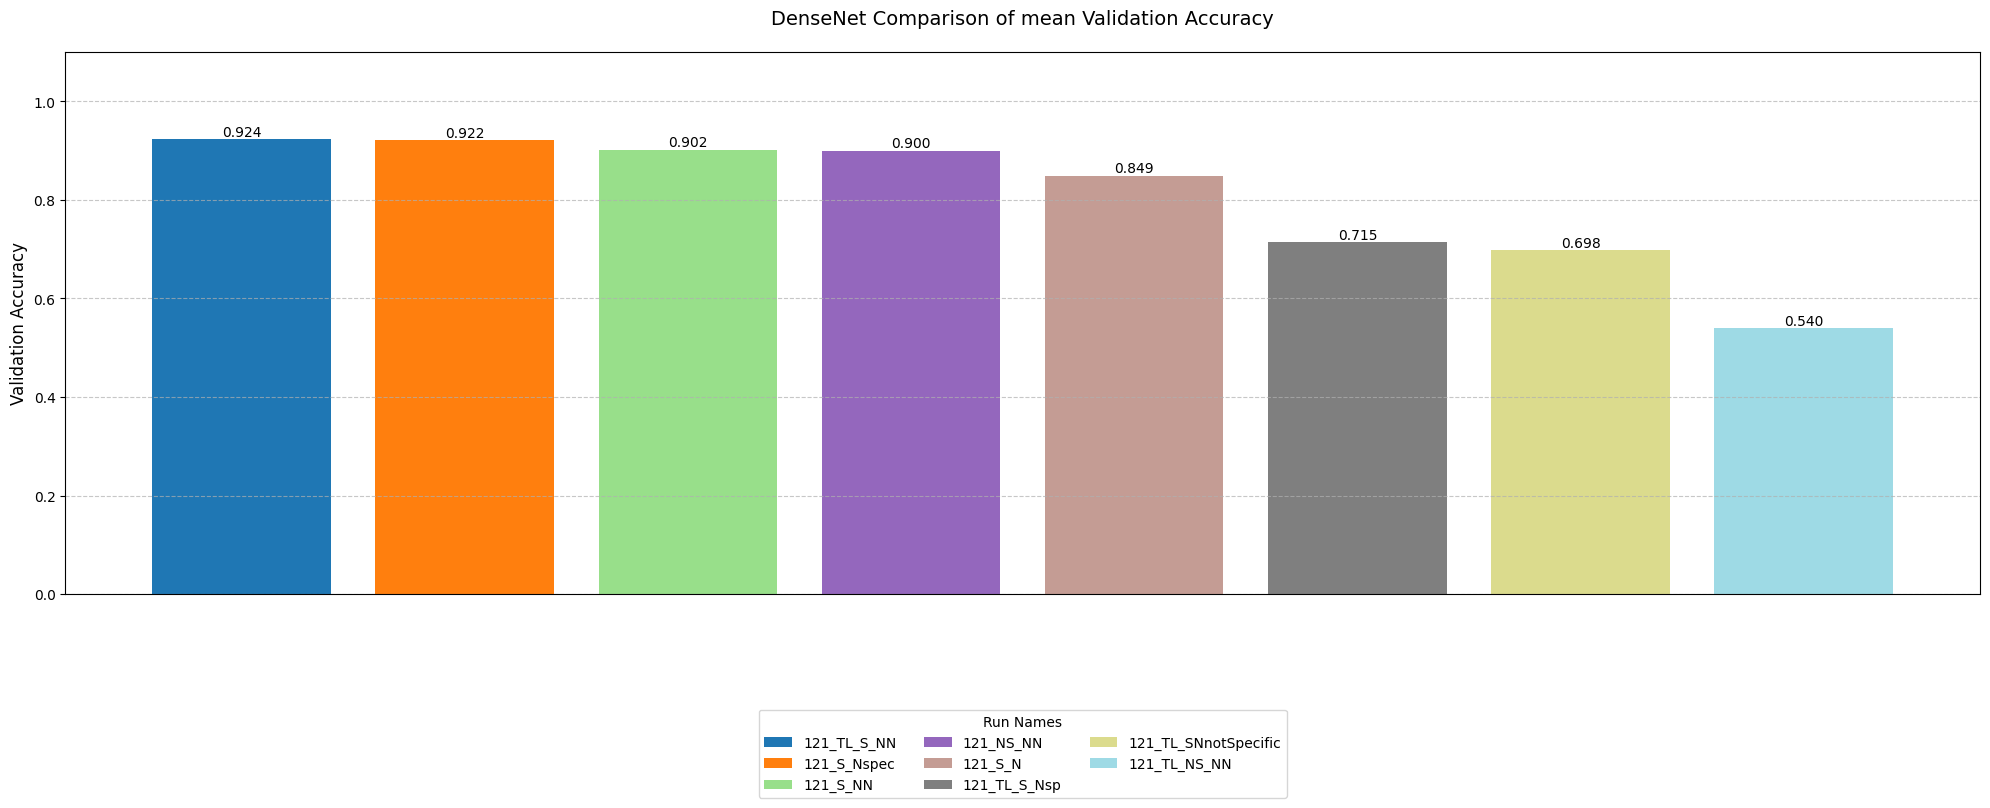

In [ ]:
combined_runs_df

In [ ]:
# 3) Plot a comparison of final validation accuracy across runs (bar plot)
# Create a copy of the run names with "DenseNet_" removed
combined_runs_df['shortened_name'] = combined_runs_df['tags.mlflow.runName'].str.replace('DenseNet', '')

# Assign unique colors to each run
unique_runs = combined_runs_df['shortened_name'].unique()
num_runs = len(unique_runs)

# Create a custom color palette with more contrasting colors
colors = plt.cm.tab20(np.linspace(0, 1, num_runs))  # 'tab20' has more distinct color steps
# Alternative colormaps you could use: 'Set3', 'Paired', 'Set1', 'Set2'

# Create a dictionary mapping run names to colors
run_color_map = {run: colors[i] for i, run in enumerate(unique_runs)}

# Add color column to DataFrame by mapping runs
combined_runs_df['color'] = combined_runs_df['shortened_name'].map(run_color_map)

# Create the plot with unique colors
plt.figure(figsize=(20, 8))

# Store bar containers for later use
bar_containers = []

# Use the 'color' column to specify bar colors
for run_name, color in run_color_map.items():
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        run_data['shortened_name'],
        run_data['metrics.mean_val_accuracy'],
        color=color,
        label=run_name
    )
    bar_containers.append(container)

# Remove x-axis tick labels
plt.xticks([])

plt.ylim(0, 1.1)
plt.title("DenseNet Comparison of mean Validation Accuracy", fontsize=14, pad=20)
plt.ylabel("Validation Accuracy", fontsize=12)

# Add value labels on top of each bar
for container in bar_containers:
    for bar in container:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend below the plot to show the run-color mapping
legend = plt.legend(title="Run Names", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust bottom spacing to accommodate the legend

plt.show()

,tags.mlflow.runName,metrics.test_accuracy,metrics.test_recall,metrics.test_precision,metrics.test_f1,metrics.val_accuracy,metrics.mean_val_accuracy,metrics.mean_val_loss,metrics.mean_val_f1
0,TL_toDeleteOnlydebug,NaN,NaN,NaN,NaN,0.576923,0.677350,0.645731,0.776351
1,DenseNet121_TL_S_Nsp,0.500000,0.25,1.000000,0.400000,0.600000,0.714545,0.564979,0.772121
2,DenseNet121_NS_NN,0.833333,1.00,0.800000,0.888889,0.800000,0.900000,0.144747,0.925275
3,DenseNet121_TL_NS_NN,0.666667,1.00,0.666667,0.800000,0.200000,0.540000,0.720090,0.629859


local_runs_df

In [ ]:
NT = no tranformation/augmentation ie flip,Rotate,RandomNoise (inside Compose)
NN = no channel wise normalization (inside Compose)
NS = no scaleIntensityd (inside compose)
NO = no fold oversampling applied
transform(all)=flip+Rotate+RandomNoise applied

KeyError: 'shortened_name'

<Figure size 2400x800 with 0 Axes>



The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.



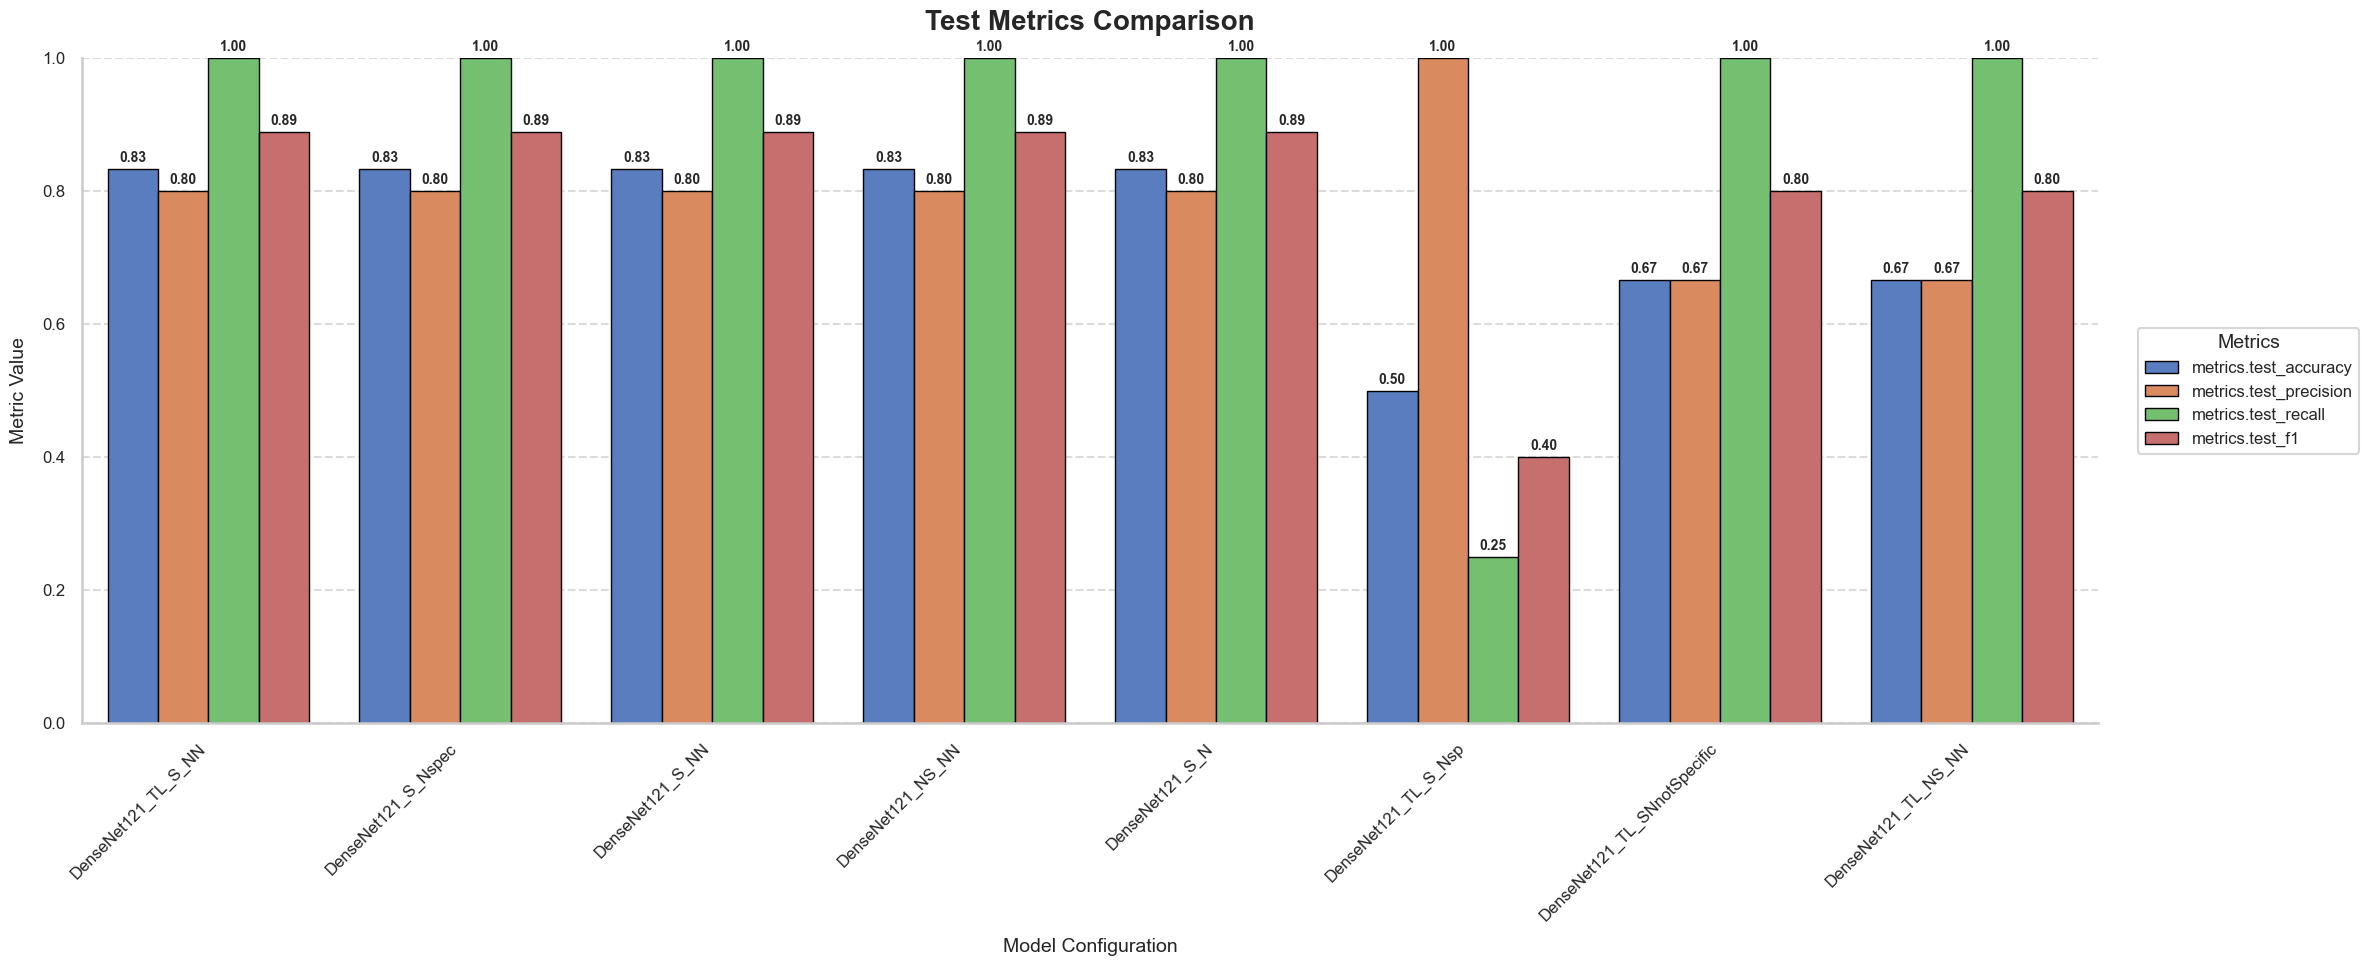

In [ ]:
plt.figure(figsize=(24, 8))
# Set width and positions for bars
width = 0.25  # Reduced width to accommodate third set of bars
x = np.arange(len(unique_runs))

# First set of bars - Validation Accuracy
acc_containers = []
for i, (run_name, color) in enumerate(run_color_map.items()):
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        x[i] - width,
        run_data['metrics.mean_val_accuracy'],
        width,
        color=color,
        label=run_name
    )
    acc_containers.append(container)

# Second set of bars - F1 Score
f1_containers = []
for i, (run_name, color) in enumerate(run_color_map.items()):
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        x[i],
        run_data['metrics.mean_val_f1'],
        width,
        color=color,
        alpha=0.7,
        hatch='/'
    )
    f1_containers.append(container)

# Third set of bars - Balanced Accuracy
# bal_acc_containers = []
# for i, (run_name, color) in enumerate(run_color_map.items()):
#     run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
#     container = plt.bar(
#         x[i] + width,
#         run_data['metrics.mean_val_balanced_accuracy'],
#         width,
#         color=color,
#         alpha=0.7,
#         hatch='x'
#     )
#     bal_acc_containers.append(container)

# Set x-axis ticks and labels
plt.xticks([])
plt.ylim(0, 1.15)
plt.title("DenseNet Comparison of Validation Metrics", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)

# Add value labels on top of each bar with alternating heights
for containers in [acc_containers, f1_containers, bal_acc_containers]:
    for container in containers:
        for idx, bar in enumerate(container):
            yval = bar.get_height()
            offset = 0.02 if idx % 2 == 0 else 0.04
            plt.text(bar.get_x() + bar.get_width()/2,
                    yval + offset,
                    f'{yval:.3f}',
                    ha='center',
                    va='bottom',
                    rotation=45,
                    fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend for run names
plt.legend(title="Run Names", bbox_to_anchor=(0.5, -0.2),
          loc='upper center', ncol=3)

# Add metric type annotations
plt.text(0.02, 1.08, "Solid bars: Accuracy", transform=plt.gca().transAxes,
         fontsize=10, ha='left')
plt.text(0.02, 1.05, "Hatched bars (/): F1 Score", transform=plt.gca().transAxes,
         fontsize=10, ha='left')
plt.text(0.02, 1.02, "Hatched bars (x): Balanced Accuracy", transform=plt.gca().transAxes,
         fontsize=10, ha='left')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
metrics_of_interest = ["metrics.test_accuracy", "metrics.test_precision", "metrics.test_recall", "metrics.test_f1"]
combined_runs_df = combined_runs_df.dropna(subset=metrics_of_interest)
combined_runs_df['shortened_name'] = combined_runs_df['tags.mlflow.runName'].str.replace('DenseNet_', '')
# 4) Create a "melted" DF to plot each test metric side by side
plot_df = combined_runs_df[["shortened_name"] + metrics_of_interest].copy()
plot_df = plot_df.melt(id_vars="shortened_name", var_name="metric", value_name="value")
# Set Seaborn style
sns.set_style("whitegrid")  # Use whitegrid style instead of plt.style.use
sns.set_palette("muted")  # Using a colorful palette
sns.set_context("talk")  # Larger context for better readability

# Create figure and axes
fig, ax = plt.subplots(figsize=(24, 10))

# Create the bar plot
sns.barplot(
    data=plot_df,
    x="shortened_name",
    y="value",
    hue="metric",
    dodge=True,
    width=0.8,
    ax=ax,
    capsize=0.05,  # Add small caps at the end of error bars
    errwidth=2,
    edgecolor='black',  # Add black edges to bars
    linewidth=1
)

# Customize the plot
ax.grid(True, linestyle='--', alpha=0.7, axis='y')
ax.set_ylim(0, 1.0)

# Customize labels and title
ax.set_title("Test Metrics Comparison", pad=20, fontsize=20, fontweight='bold')
ax.set_xlabel("Model Configuration", fontsize=14, labelpad=10)
ax.set_ylabel("Metric Value", fontsize=14, labelpad=10)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Customize legend
legend = ax.legend(
    title="Metrics",
    title_fontsize=14,
    fontsize=12,
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0
)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        padding=3,
        fontsize=10,
        fontweight='bold'
    )

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the plot with high DPI
# plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')

,tags.mlflow.runName,metrics.test_accuracy,metrics.test_recall,metrics.test_precision,metrics.test_f1,metrics.val_accuracy,metrics.mean_val_accuracy,metrics.mean_val_loss,metrics.mean_val_f1,shortened_name,color
7,DenseNet121_TL_S_NN,0.833333,1.00,0.800000,0.888889,0.9,0.923636,0.093885,0.946429,DenseNet121_TL_S_NN,"[0.12156862745098039, 0.4666666666666667, 0.70..."
8,DenseNet121_S_Nspec,0.833333,1.00,0.800000,0.888889,0.8,0.921818,0.100582,0.942711,DenseNet121_S_Nspec,"[1.0, 0.4980392156862745, 0.054901960784313725..."
4,DenseNet121_S_NN,0.833333,1.00,0.800000,0.888889,0.8,0.901818,0.137334,0.931282,DenseNet121_S_NN,"[0.596078431372549, 0.8745098039215686, 0.5411..."
2,DenseNet121_NS_NN,0.833333,1.00,0.800000,0.888889,0.8,0.900000,0.144747,0.925275,DenseNet121_NS_NN,"[0.5803921568627451, 0.403921568627451, 0.7411..."
6,DenseNet121_S_N,0.833333,1.00,0.800000,0.888889,0.7,0.849091,0.366441,0.899608,DenseNet121_S_N,"[0.7686274509803922, 0.611764705882353, 0.5803..."
1,DenseNet121_TL_S_Nsp,0.500000,0.25,1.000000,0.400000,0.6,0.714545,0.564979,0.772121,DenseNet121_TL_S_Nsp,"[0.4980392156862745, 0.4980392156862745, 0.498..."
9,DenseNet121_TL_SNnotSpecific,0.666667,1.00,0.666667,0.800000,0.7,0.698182,0.643753,0.780732,DenseNet121_TL_SNnotSpecific,"[0.8588235294117647, 0.8588235294117647, 0.552..."
3,DenseNet121_TL_NS_NN,0.666667,1.00,0.666667,0.800000,0.2,0.540000,0.720090,0.629859,DenseNet121_TL_NS_NN,"[0.6196078431372549, 0.8549019607843137, 0.898..."
